In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from matplotlib.ticker import MaxNLocator

from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import torch.autograd as autograd
from torchviz import make_dot
from torchsummary import summary
from termcolor import colored
import seaborn as sns
sns.set()


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel
from scipy.stats import wasserstein_distance, entropy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
reserved = int(torch.cuda.max_memory_reserved() / 1000 / 1000)
gpu_available = torch.cuda.is_available()

print(colored(f"GPU available! {torch.cuda.get_device_name()}. Memory reserved: {reserved}MB", "green") if gpu_available else colored("No GPU. Running on CPU", "red"))

No GPU. Running on CPU


In [3]:
device = "mps"

## Research Notes and Progress

**Current Status**
1. Should we do $X_{t0} \rightarrow NEE_{t1}$ instead of current $X_{t0} \rightarrow NEE_{t0}$ and see if we beat RFR at this
2. MSE experiments
3. Architecture experiments

In [4]:
timestamp = datetime.datetime.now()
timestamp = f"{timestamp.year}-{timestamp.month}-{timestamp.day}_{timestamp.hour}-{timestamp.minute}-{timestamp.second}-{timestamp.microsecond}"

save_dir = Path(timestamp)
if save_dir.exists():
    raise f"Directory exists: {save_dir.as_posix()}"
os.makedirs(save_dir.as_posix())

In [5]:
config = DotMap({"flux_model": "night"})

In [6]:
writer = SummaryWriter(save_dir.joinpath("tensorboard"))

## Model Building and Training

### Data

In [7]:
data = pd.read_parquet("../data_manipulation/final_night_data.parquet")

In [8]:
data.TER

0        4.03557
1        4.05446
2        4.04737
3        4.00259
4        4.00024
          ...   
59095    0.66040
59096    0.65328
59097    0.64973
59098    0.65125
59099    0.65277
Name: TER, Length: 59100, dtype: float64

In [12]:
np.mean(data.NEE - data.TER), np.std(data.NEE - data.TER)

(-0.009990433748718356, 2.029142465085828)

In [8]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]
    
def split_data(df, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    test_size (float): Proportion of the data to include in the test split.
    
    Returns:
    tuple: Training and test DataFrames.
    """
    train_data, test_data = train_test_split(df, test_size=test_size, shuffle=False)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [9]:
drivers = np.array(['Ta', 'H', 'Tau', 'LE_strg', 'RH', 'VPD', 'Rg', 'Ustar', 'Tsoil1', 'Tsoil2'])

In [10]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [11]:
data = data[data["dNEE"].notna()].reset_index(drop=True)

In [12]:
data.shape

(21535, 76)

In [13]:
drivers = np.concatenate([drivers, [season_feat], time_feat])

In [14]:
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

In [15]:
data["NEE_phy"] = physics_nee(data[["E0", "rb"]].values, data.Ta.values)

### Noise Distribution and Calculating diffusion coefficient $\sigma_{night}$

In [16]:
phy_error = data.NEE - data.NEE_phy
noise_mu = np.mean(phy_error)
noise_std = np.std(phy_error)

### Training Data 

In [17]:
train_data, test_data = split_data(data)

In [18]:
X_train = train_data[drivers]
NEE_train = train_data["NEE_next"]
T_train = train_data["Ta"]
dT_train = train_data["dTa"]
dNEE_train = train_data["dNEE"]
bNEE_train = train_data["NEE"]
K_train = train_data[["E0", "rb"]]

X_test = test_data[drivers]
NEE_test = test_data["NEE_next"]
T_test = train_data["Ta"]
dT_test = test_data["dTa"]
dNEE_test = test_data["dNEE"]
bNEE_test = test_data["NEE"]
K_test = test_data[["E0", "rb"]]


In [19]:
normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [20]:
with open(save_dir.joinpath("normalizer.pickle"), "wb") as fp:
    pickle.dump(normalizer, fp)

In [21]:
config.data.X = drivers.tolist()
config.data.train_size = X_train.shape[0]
config.data.train_start_date = train_data["DateTime"].iloc[0].ctime()
config.data.train_end_date = train_data["DateTime"].iloc[-1].ctime()
config.data.test_size = X_test.shape[0]
config.data.test_start_date = test_data["DateTime"].iloc[0].ctime()
config.data.test_end_date = test_data["DateTime"].iloc[-1].ctime()


### Model Building

In [22]:
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        # Apply He initialization
        nn.init.xavier_uniform_(layer.weight)
        #init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

In [23]:
class PIAE_SDE(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_dims, decoder_dims, nee_decoder_dims=None, noise_dims=[4], activation=nn.Tanh, hard_z=False):
        super(PIAE_SDE, self).__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.Tref = torch.tensor(10).to(device)
        self.T0 = torch.tensor(46.02).to(device)
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims
        self.noise_dims = noise_dims
        self.nee_decoder_dims = decoder_dims if nee_decoder_dims is None else nee_decoder_dims
        self.k_min = torch.tensor([50, 0.0001]).view((-1, 2)).to(device)
        self.k_max = torch.tensor([400, 20]).view((-1, 2)).to(device)
        
        # Encoder network
        modules = self.append_linear_modules(self.input_dim, self.encoder_dims)
        modules.append(nn.Linear(self.encoder_dims[-1], self.latent_dim))
        print(modules)
        self.encoder = nn.Sequential(*modules)

       # Decoder network for NEE (u)
        modules = self.append_linear_modules(self.latent_dim, self.nee_decoder_dims) 
        modules.append(nn.Linear(self.nee_decoder_dims[-1], 1))
        self.nee_decoder = nn.Sequential(*modules)

        # Noise
        modules = self.append_linear_modules(self.latent_dim, self.noise_dims)
        mu_modules = modules + [nn.Linear(self.noise_dims[-1], 1)]
        logvar_modules = modules + [nn.Linear(self.noise_dims[-1], 1)]
        
        self.fc_mu = nn.Sequential(*mu_modules)
        self.fc_logvar = nn.Sequential(*logvar_modules)
        
        # Decoder network for dT/dt (f)
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims) 
        modules.append(nn.Linear(self.decoder_dims[-1], 1))
        self.temp_derivative_decoder = nn.Sequential(*modules)

        
        # Decoder network for E0 and rb
        modules = self.append_linear_modules(self.latent_dim, self.decoder_dims, nn.LeakyReLU(negative_slope=0.01)) 
        modules.append(nn.Linear(self.decoder_dims[-1], 2))
        modules.append(nn.LeakyReLU(negative_slope=0.01))
        self.k_decoder = nn.Sequential(*modules)

    def append_linear_modules(self, in_dim, dims, activation=None):
        modules = []
        for i, dim in enumerate(dims):
            modules.append(nn.Linear(in_dim, dim))
            #if i != len(dims) - 1:
            modules.append(self.activation()) if not activation else modules.append(activation)
            in_dim = dim
        return modules

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x, b, k, T):
        input_ = torch.cat((x, b.view(x.shape[0], 1), k), dim=1).to(device)
        z = self.encoder(input_)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        noise = self.reparameterize(mu, logvar)
        
        nee = self.nee_decoder(z) + noise
        dT_dt = self.temp_derivative_decoder(z)
        k_pred = self.k_decoder(z)
        f, residual = self.physics_residual(nee, x, k_pred, T.view((-1, 1)), dT_dt, noise)
        
        return nee, dT_dt, k_pred, f, z, residual, noise

    def physics_residual(self, nee, x, k, T, dT_dt, noise):
        self.E0 = k[:, 0].view((-1, 1))
        self.rb = k[:, 1].view((-1, 1))
        
        # Compute dNEE/dT using predicted E0 and rb
        self.exp_term = torch.exp(self.E0 * (1.0 / (self.Tref - self.T0) - 1.0 / (T - self.T0))).view((-1, 1))
        self.dNEE_dT = self.rb * (self.E0 / (T - self.T0)**2) * self.exp_term

        # Physics-based residual f = dNEE/dt - (dNEE/dT) * (dT/dt)
        #f_residual = autograd.grad(nee, x, grad_outputs=torch.ones_like(nee), create_graph=True)[:, 0]
        residual = torch.zeros_like(nee) #f_residual - dNEE_dT * dT_dt
 
        f = self.dNEE_dT * dT_dt
        
        return f, residual
        # Incorporate boundary condition (NEE_t should be close to NEE_{t-1})

In [24]:
def loss_function(nee_pred, nee_true, bnee_pred, bnee_true, noise, noise_prior, temp_pred, temp_true, E0_rb_pred, E0_rb_true, f_pred, f_true, physics_residual, loss_fn):
    # Loss for NEE (u)
    loss_nee = loss_fn(nee_pred, nee_true) 

    loss_bnee = loss_fn(bnee_pred, bnee_true) 

    # Loss for dNEE (f)
    f_loss = loss_fn(f_pred, f_true)

    # MMD Loss on Noise
    noise_loss = MMD_loss()(noise, noise_prior)
    
    # Loss for E0 and rb (k)
    E0_pred, rb_pred = E0_rb_pred[:, 0], E0_rb_pred[:, 1]
    E0_true, rb_true = E0_rb_true[:, 0], E0_rb_true[:, 1]

    loss_E0 = loss_fn(E0_pred.view((-1, 1)), E0_true.view((-1, 1)))
    loss_rb = loss_fn(rb_pred.view((-1, 1)), rb_true.view((-1, 1)))
    
    # loss for temperature derivative (f)
    temp_loss = loss_fn(temp_pred.view((-1, 1)), temp_true.view((-1, 1)))
    
    # Physics-based loss (ensure the solution satisfies the physics model)
    physics_loss = torch.mean(physics_residual ** 2)
    
    # Total loss
    # total_loss = loss_nee + loss_E0 + loss_rb + temp_loss + physics_loss + f_loss
    return loss_nee, loss_bnee, loss_E0, loss_rb , temp_loss , physics_loss , f_loss, noise_loss


In [25]:
class MMD_loss(nn.Module):
    'description'
    # function class which calculates the MMD distance of 2 distributions

    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()

        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    
    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)

        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.guassian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [26]:
class ClimateDataset(Dataset):
    def __init__(self, X, k, T, dNEE, bNEE, dT, NEE):
        """
        Args:
            X (numpy array): Input data of shape (n_samples, input_dim)
            k (numpy array): Ground truth for E0 and rb, shape (n_samples, 2)
            T (numpy array): Ground truth for Tair, shape (n_samples, 1)
            dNEE (numpy array): Ground truth for f, shape (n_samples, 1)
            bNEE (numpy array): Ground truth for NEE at current t (boundary condition), shape (n_samples, 1)
            dT (numpy array): Ground truth for temperature derivative, shape (n_samples, 1)
            NEE (numpy array): Ground truth for NEE at t + 1, shape (n_samples, 1)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.k = torch.tensor(k, dtype=torch.float32)
        self.T = torch.tensor(T, dtype=torch.float32)
        self.dNEE = torch.tensor(dNEE, dtype=torch.float32)
        self.bNEE = torch.tensor(bNEE, dtype=torch.float32)
        self.dT = torch.tensor(dT, dtype=torch.float32)
        self.NEE = torch.tensor(NEE, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Get current NEE and previous NEE for boundary condition        
        return {
            'X': self.X[idx],
            'k': self.k[idx],
            'T': self.T[idx],
            'dNEE': self.dNEE[idx],
            'bNEE': self.bNEE[idx],
            'dT': self.dT[idx],
            'NEE': self.NEE[idx]
        }


### Training Setup

In [44]:
lr = 1e-3
torch.manual_seed(41)

model = PIAE_SDE(input_dim=X_train.shape[1] + 3, latent_dim=32, encoder_dims=[16, 16], decoder_dims = [16, 16], activation=nn.ReLU)
model.apply(initialize_weights)
with open(save_dir.joinpath("model.txt"), "w") as fp:
    fp.write(str(model))

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assuming X, k, dNEE, dT, and NEE are numpy arrays you have
train_dataset = ClimateDataset(X_train, K_train.values, T_train.values, dNEE_train.values, bNEE_train.values, dT_train.values, NEE_train.values)
test_dataset = ClimateDataset(X_test, K_test.values, T_test.values, dNEE_test.values, bNEE_test.values, dT_test.values, NEE_test.values)

# Create a DataLoader instance
train_data_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

[Linear(in_features=18, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=16, bias=True), ReLU(), Linear(in_features=16, out_features=32, bias=True)]


In [45]:
model

PIAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (fc_logvar): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    

In [46]:
loss_fn = nn.MSELoss()

config.model.activation = str(model.activation)
config.model.lr = lr
config.model.loss_fn = str(loss_fn)

with open(save_dir.joinpath("loss_function.txt"), "w") as fp:
    fp.write(inspect.getsource(loss_function))

In [47]:
for batch in train_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    T = batch['T'].to(device)
    yhat = model(x, b, k, T)

    
    input_ = torch.cat((x, b.view(x.shape[0], 1), k), dim=1).to(device)
    z = model.encoder(input_)
    mu = model.fc_mu(z)
    logvar = model.fc_logvar(z)
    noise = model.reparameterize(mu, logvar)
    
    nee_pred = model.nee_decoder(z) + noise
    dT_dt = model.temp_derivative_decoder(z)
    k_pred = model.k_decoder(z)
    f, residual = model.physics_residual(nee_pred, x, k_pred, T.view((-1, 1)), dT_dt, noise)

    print(nee_pred)
    break

make_dot(yhat, params=dict(list(model.named_parameters()))).render(save_dir.joinpath("pivae"), format="png")

tensor([[2.3305],
        [3.1959],
        [3.6497],
        [1.1169],
        [1.5720],
        [2.3208],
        [3.5640],
        [2.3465],
        [2.0569],
        [0.9836],
        [2.5402],
        [3.2856],
        [1.7076],
        [2.6542],
        [2.6880],
        [2.1906],
        [0.9821],
        [2.0773],
        [2.4710],
        [1.0637],
        [3.0992],
        [1.5956],
        [3.1883],
        [2.4311],
        [2.1906],
        [3.2666],
        [3.9336],
        [1.8930],
        [3.7186],
        [2.4816],
        [1.2745],
        [2.0134],
        [3.6182],
        [2.0344],
        [1.0638],
        [2.0691],
        [1.1473],
        [0.7731],
        [3.0269],
        [2.7306],
        [2.0247],
        [2.2520],
        [1.4277],
        [2.6722],
        [2.3111],
        [3.5357],
        [1.2206],
        [2.1468],
        [3.6809],
        [3.1229],
        [2.7119],
        [3.2238],
        [1.8102],
        [3.0766],
        [3.2438],
        [1

'2024-11-27_14-37-46-545510/pivae.png'

In [48]:
num_epochs = 500
patience = 50
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

config.training.patience = patience
config.training.num_epochs = num_epochs

In [49]:
with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

### Training

In [50]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [51]:
epoch = 0

##### Control Room

In [55]:
# CONTROL ROOM
loss_fn =  nn.MSELoss()
for g in optimizer.param_groups:
    g['lr'] = 0.0001

In [53]:
mse_factor = 1
mmd_factor = 1
f_factor = 1

##### Back to training

In [56]:

while epoch < num_epochs:

    print(colored("Epoch: {}".format(epoch), "red"))
    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mse_loss_nee": [],"mmd_loss_nee": [],  "mse_loss_bnee": [],"mmd_loss_bnee": [], "mse_loss_E0": [],"mse_loss_rb": [],"mse_temp_loss": [], "physics_loss": [] , "noise_loss": [], "mse_f_loss": []})
    # Example of iterating over the DataLoader in the training loop
    
    for batch in train_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)
                
        bnee_pred, dT_dt_pred, k_pred, f_pred, z, residual, noise = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        noise_prior = torch.randn_like(noise) * noise_std + noise_mu
        
        # Compute loss

        nee_pred = bnee_pred + f_pred
        
        mse_loss_nee, mse_loss_bnee, mse_loss_E0, mse_loss_rb , mse_loss_temp , physics_loss , mse_loss_f, noise_loss = loss_function(nee_pred, nee, bnee_pred, b, noise, noise_prior, dT_dt_pred, dtemp, k_pred, k, f_pred, f, residual, loss_fn)
        mse_loss_f = mse_loss_f * f_factor
        noise_loss = noise_loss * f_factor

        
        mse_loss = mse_loss_nee+ mse_loss_bnee + mse_loss_E0+ mse_loss_rb + mse_loss_temp + physics_loss + mse_loss_f
        mmd_loss_nee = MMD_loss()(nee, nee_pred)
        mmd_loss_bnee = MMD_loss()(b, bnee_pred)
        
        loss = mse_factor * mse_loss + mmd_factor * noise_loss + mmd_factor * (mmd_loss_nee + mmd_loss_bnee)

        train_losses.mse_loss_nee.append(mse_loss_nee)
        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mse_loss_bnee.append(mse_loss_bnee)
        train_losses.mmd_loss_bnee.append(mmd_loss_bnee)
        train_losses.noise_loss.append(noise_loss)
        train_losses.mse_loss_E0.append(mse_loss_E0)
        train_losses.mse_loss_rb.append(mse_loss_rb)
        train_losses.mse_temp_loss.append(mse_loss_temp)
        train_losses.physics_loss.append(physics_loss)
        train_losses.mse_f_loss.append(mse_loss_f)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    
    writer.add_scalar(f"Train Loss", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}]", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mse_loss_nee": [],"mmd_loss_nee": [],  "mse_loss_bnee": [],"mmd_loss_bnee": [], "mse_loss_E0": [],"mse_loss_rb": [],"mse_temp_loss": [], "physics_loss": [] , "noise_loss": [], "mse_f_loss": []})

    for batch in test_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device).view(-1, 1)
        b = batch['bNEE'].to(device).view(-1, 1)
        T = batch['T'].to(device).view(-1, 1)
        dtemp = batch['dT'].to(device).view(-1, 1)
        nee = batch['NEE'].to(device).view(-1, 1)
                
        bnee_pred, dT_dt_pred, k_pred, f_pred, z, residual, noise = model(x, b, k, T)
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        noise_prior = torch.randn_like(noise) * noise_std + noise_mu
        
        # Compute loss

        nee_pred = bnee_pred + f_pred
        
        mse_loss_nee, mse_loss_bnee, mse_loss_E0, mse_loss_rb , mse_loss_temp , physics_loss , mse_loss_f, noise_loss = loss_function(nee_pred, nee, bnee_pred, b, noise, noise_prior, dT_dt_pred, dtemp, k_pred, k, f_pred, f, residual, loss_fn)
        mse_loss_f = mse_loss_f * f_factor
        noise_loss = noise_loss * f_factor

        
        mse_loss = mse_loss_nee+ mse_loss_bnee + mse_loss_E0+ mse_loss_rb + mse_loss_temp + physics_loss + mse_loss_f
        mmd_loss_nee = MMD_loss()(nee, nee_pred)
        mmd_loss_bnee = MMD_loss()(b, bnee_pred)
        
        loss = mse_factor * mse_loss + mmd_factor * noise_loss + mmd_factor * (mmd_loss_nee + mmd_loss_bnee)

        test_losses.mse_loss_nee.append(mse_loss_nee)
        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mse_loss_bnee.append(mse_loss_bnee)
        test_losses.mmd_loss_bnee.append(mmd_loss_bnee)
        test_losses.noise_loss.append(noise_loss)
        test_losses.mse_loss_E0.append(mse_loss_E0)
        test_losses.mse_loss_rb.append(mse_loss_rb)
        test_losses.mse_temp_loss.append(mse_loss_temp)
        test_losses.physics_loss.append(physics_loss)
        test_losses.mse_f_loss.append(mse_loss_f)

    test_loss.append(loss.cpu().detach().numpy())

    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}]", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1
    # if epoch % 140 == 0:
    #     print("Reducing LR")
    #     optimizer.param_groups[0]['lr'] = 0.0001
        




Epoch: 79
Training Loss: 2.8438069820404053
mse_loss_nee 2.3779483 mmd_loss_nee 0.005385954 mse_loss_bnee 0.17388934 mmd_loss_bnee 0.0014678692 mse_loss_E0 0.0043029496 mse_loss_rb 0.015911235 mse_temp_loss 0.008737701 physics_loss 0.0 noise_loss 0.23377779 mse_f_loss 0.022385657 

Test Loss: 3.5910239219665527
mse_loss_nee 2.8244143 mmd_loss_nee 0.003844493 mse_loss_bnee 0.23114651 mmd_loss_bnee 0.0012190072 mse_loss_E0 0.0030642769 mse_loss_rb 0.016778724 mse_temp_loss 0.01121826 physics_loss 0.0 noise_loss 0.40363458 mse_f_loss 0.021128569 


Epoch: 80
Training Loss: 2.8293936252593994
mse_loss_nee 2.3706932 mmd_loss_nee 0.0058016805 mse_loss_bnee 0.17095186 mmd_loss_bnee 0.0013532892 mse_loss_E0 0.0032861936 mse_loss_rb 0.0149450945 mse_temp_loss 0.008362117 physics_loss 0.0 noise_loss 0.23216249 mse_f_loss 0.02183747 

Test Loss: 2.2412257194519043
mse_loss_nee 2.7789593 mmd_loss_nee 0.005476826 mse_loss_bnee 0.22508393 mmd_loss_bnee 0.0018663302 mse_loss_E0 0.0025915657 mse_loss_

KeyboardInterrupt: 

In [57]:
model.load_state_dict(torch.load(f"{save_dir}/best_model.pth", weights_only=True))


<All keys matched successfully>

In [58]:
model.eval()

PIAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (fc_logvar): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    

## Evaluation and Analysis

In [59]:
def compute_mmd(Y, Y_hat, kernel='rbf', gamma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - kernel: string, type of kernel ('rbf', 'linear')
    - gamma: float, kernel coefficient for RBF kernel
    
    Returns:
    - float: MMD value
    """
    Y = Y.reshape(-1, 1)  # Reshape if Y is a 1D array
    Y_hat = Y_hat.reshape(-1, 1)  # Reshape if Y_hat is a 1D array

    if kernel == 'rbf':
        K_yy = rbf_kernel(Y, Y, gamma=gamma)
        K_yhatyhat = rbf_kernel(Y_hat, Y_hat, gamma=gamma)
        K_yyhat = rbf_kernel(Y, Y_hat, gamma=gamma)
    elif kernel == 'linear':
        K_yy = np.dot(Y, Y.T)
        K_yhatyhat = np.dot(Y_hat, Y_hat.T)
        K_yyhat = np.dot(Y, Y_hat.T)
    else:
        raise ValueError("Unsupported kernel")

    mmd = np.mean(K_yy) + np.mean(K_yhatyhat) - 2 * np.mean(K_yyhat)
    return np.sqrt(mmd)

from scipy.stats import entropy

def compute_kl_divergence(Y, Y_hat, bins=100):
    """
    Compute the Kullback-Leibler (KL) Divergence between ground truth Y and predictions Y_hat.
    
    Parameters:
    - Y: numpy array, ground truth labels
    - Y_hat: numpy array, predicted labels
    - bins: int, number of bins for histogram
    
    Returns:
    - float: KL Divergence
    """
    hist_Y, bin_edges = np.histogram(Y, bins=bins, density=True)
    hist_Y_hat, _ = np.histogram(Y_hat, bins=bin_edges, density=True)

    # Adding a small epsilon to avoid log(0)
    epsilon = 1e-10
    hist_Y = hist_Y + epsilon
    hist_Y_hat = hist_Y_hat + epsilon

    # Normalize the histograms
    hist_Y /= np.sum(hist_Y)
    hist_Y_hat /= np.sum(hist_Y_hat)

    return entropy(hist_Y, hist_Y_hat)


In [60]:

for batch in test_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    T = batch['T'].to(device)
    dtemp = batch['dT'].to(device)
    nee = batch['NEE'].to(device)
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual, noise = model(x, b, k, T)
    print(z)
    break

tensor([[  6.3622, -13.7956,  -2.3806,  ...,  11.8651, -13.2759,  17.3589],
        [  4.3008,  -9.6091,  -1.3142,  ...,   8.2589,  -9.1914,  12.0606],
        [  8.7731, -19.1060,  -3.3436,  ...,  16.6063, -18.6583,  24.3181],
        ...,
        [  7.3150, -15.6183,  -3.4563,  ...,  13.7729, -15.4764,  20.6457],
        [  7.1205, -13.5841,  -2.6903,  ...,  12.4659, -15.1308,  17.6759],
        [  8.9587, -20.7656,  -2.9996,  ...,  17.9293, -19.8305,  25.7899]],
       device='mps:0', grad_fn=<LinearBackward0>)


In [61]:
preds = DotMap({"nee": [],"bnee": [], "E0": [], "rb": [] , "dtemp": [] , "f": [], "z": [], "noise": [], "noise_mus": [], "noise_stds": []})
gt = DotMap({"nee": [],"bnee": [],  "E0": [], "rb": [] , "dtemp": [] , "f": []})



for batch in test_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    T = batch['T'].to(device)
    dtemp = batch['dT'].to(device)
    nee = batch['NEE'].to(device)

    input_ = torch.cat((x, b.view(x.shape[0], 1), k), dim=1).to(device)
    z = model.encoder(input_)
    noise_m = model.fc_mu(z)
    noise_lv = model.fc_logvar(z)
    noise = model.reparameterize(noise_m, noise_lv)
    
    bnee_pred = model.nee_decoder(z) + noise
    dT_dt_pred = model.temp_derivative_decoder(z)
    k_pred = model.k_decoder(z)
    f_pred, residual = model.physics_residual(bnee_pred, x, k_pred, T.view((-1, 1)), dT_dt_pred, noise)


    nee_pred = bnee_pred + f_pred
    
    #nee_pred, dT_dt_pred, k_pred, f_pred, z, residual, noise = model(x, b, k)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

    # z = model.encoder(x, b, k)
    # noise_mu = model.fc_mu(z)
    # noise_logvar = model.fc_logvar(z)
    noise_s = torch.exp(0.5 * noise_lv)
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.bnee.extend(bnee_pred.cpu().detach().numpy().tolist())
    preds.noise.extend(noise.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    preds.z.extend(z.cpu().detach().numpy().tolist())
    preds.noise_mus.extend(noise_m.cpu().detach().numpy().tolist())
    preds.noise_stds.extend(noise_s.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.bnee.extend(b.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [62]:
print(colored("Metrics ", "red"))
for col in gt:
    print(col)
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.j1on"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee
nee 
MMD: 0.02410415432288397, Wasstn: 0.15568965544165544, KL: 0.040499118033707565, MAE: 0.8386791015211243, R2: 0.7304776803864585
bnee
bnee 
MMD: 0.02049194187288839, Wasstn: 0.11800448966869652, KL: 0.08803885579266343, MAE: 0.26213267909979043, R2: 0.9796421539583849
E0
E0 
MMD: 0.005574661390532011, Wasstn: 0.03398294157097489, KL: 0.1608611107174421, MAE: 0.034581969390635736, R2: 0.9999978632828294
rb
rb 
MMD: 0.019105821974984376, Wasstn: 0.059600713604038985, KL: 0.7154083600469092, MAE: 0.07669753075557731, R2: 0.9978095889652087
dtemp
dtemp 
MMD: 0.06331097353810514, Wasstn: 0.06549541541219907, KL: 0.7482737734756528, MAE: 0.07325818799029028, R2: -85.8906232501655
f
f 
MMD: 0.04435920402681272, Wasstn: 0.03667605226817244, KL: 0.2611385655520497, MAE: 0.05829123681711453, R2: -3.3825552925165274


In [63]:
preds.noise_stds, preds.noise_mus

(array([5.24925222e-21, 7.89759795e-08, 2.44285605e-18, ...,
        3.62765142e-08, 5.09733509e-18, 2.97123415e-12]),
 array([-5.44476461, -0.08570091, -1.99046981, ..., -0.66410494,
        -4.25365829, -3.08685994]))

In [64]:
preds.nee, gt.nee, preds.noise


(array([1.46934319, 1.79553306, 2.29548717, ..., 2.12172174, 1.1426264 ,
        0.82977039]),
 array([0.98399001, 1.72249997, 6.23519993, ..., 2.02649999, 2.05369997,
        1.15649998]),
 array([-5.44476461, -0.08570088, -1.99046981, ..., -0.66410488,
        -4.25365829, -3.08685994]))

In [65]:
preds.noise_stds

array([5.24925222e-21, 7.89759795e-08, 2.44285605e-18, ...,
       3.62765142e-08, 5.09733509e-18, 2.97123415e-12])

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_59628/1224721900.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_59628/1224721900.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_59628/1224721900.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis_raw, 'go-', color="green", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_596

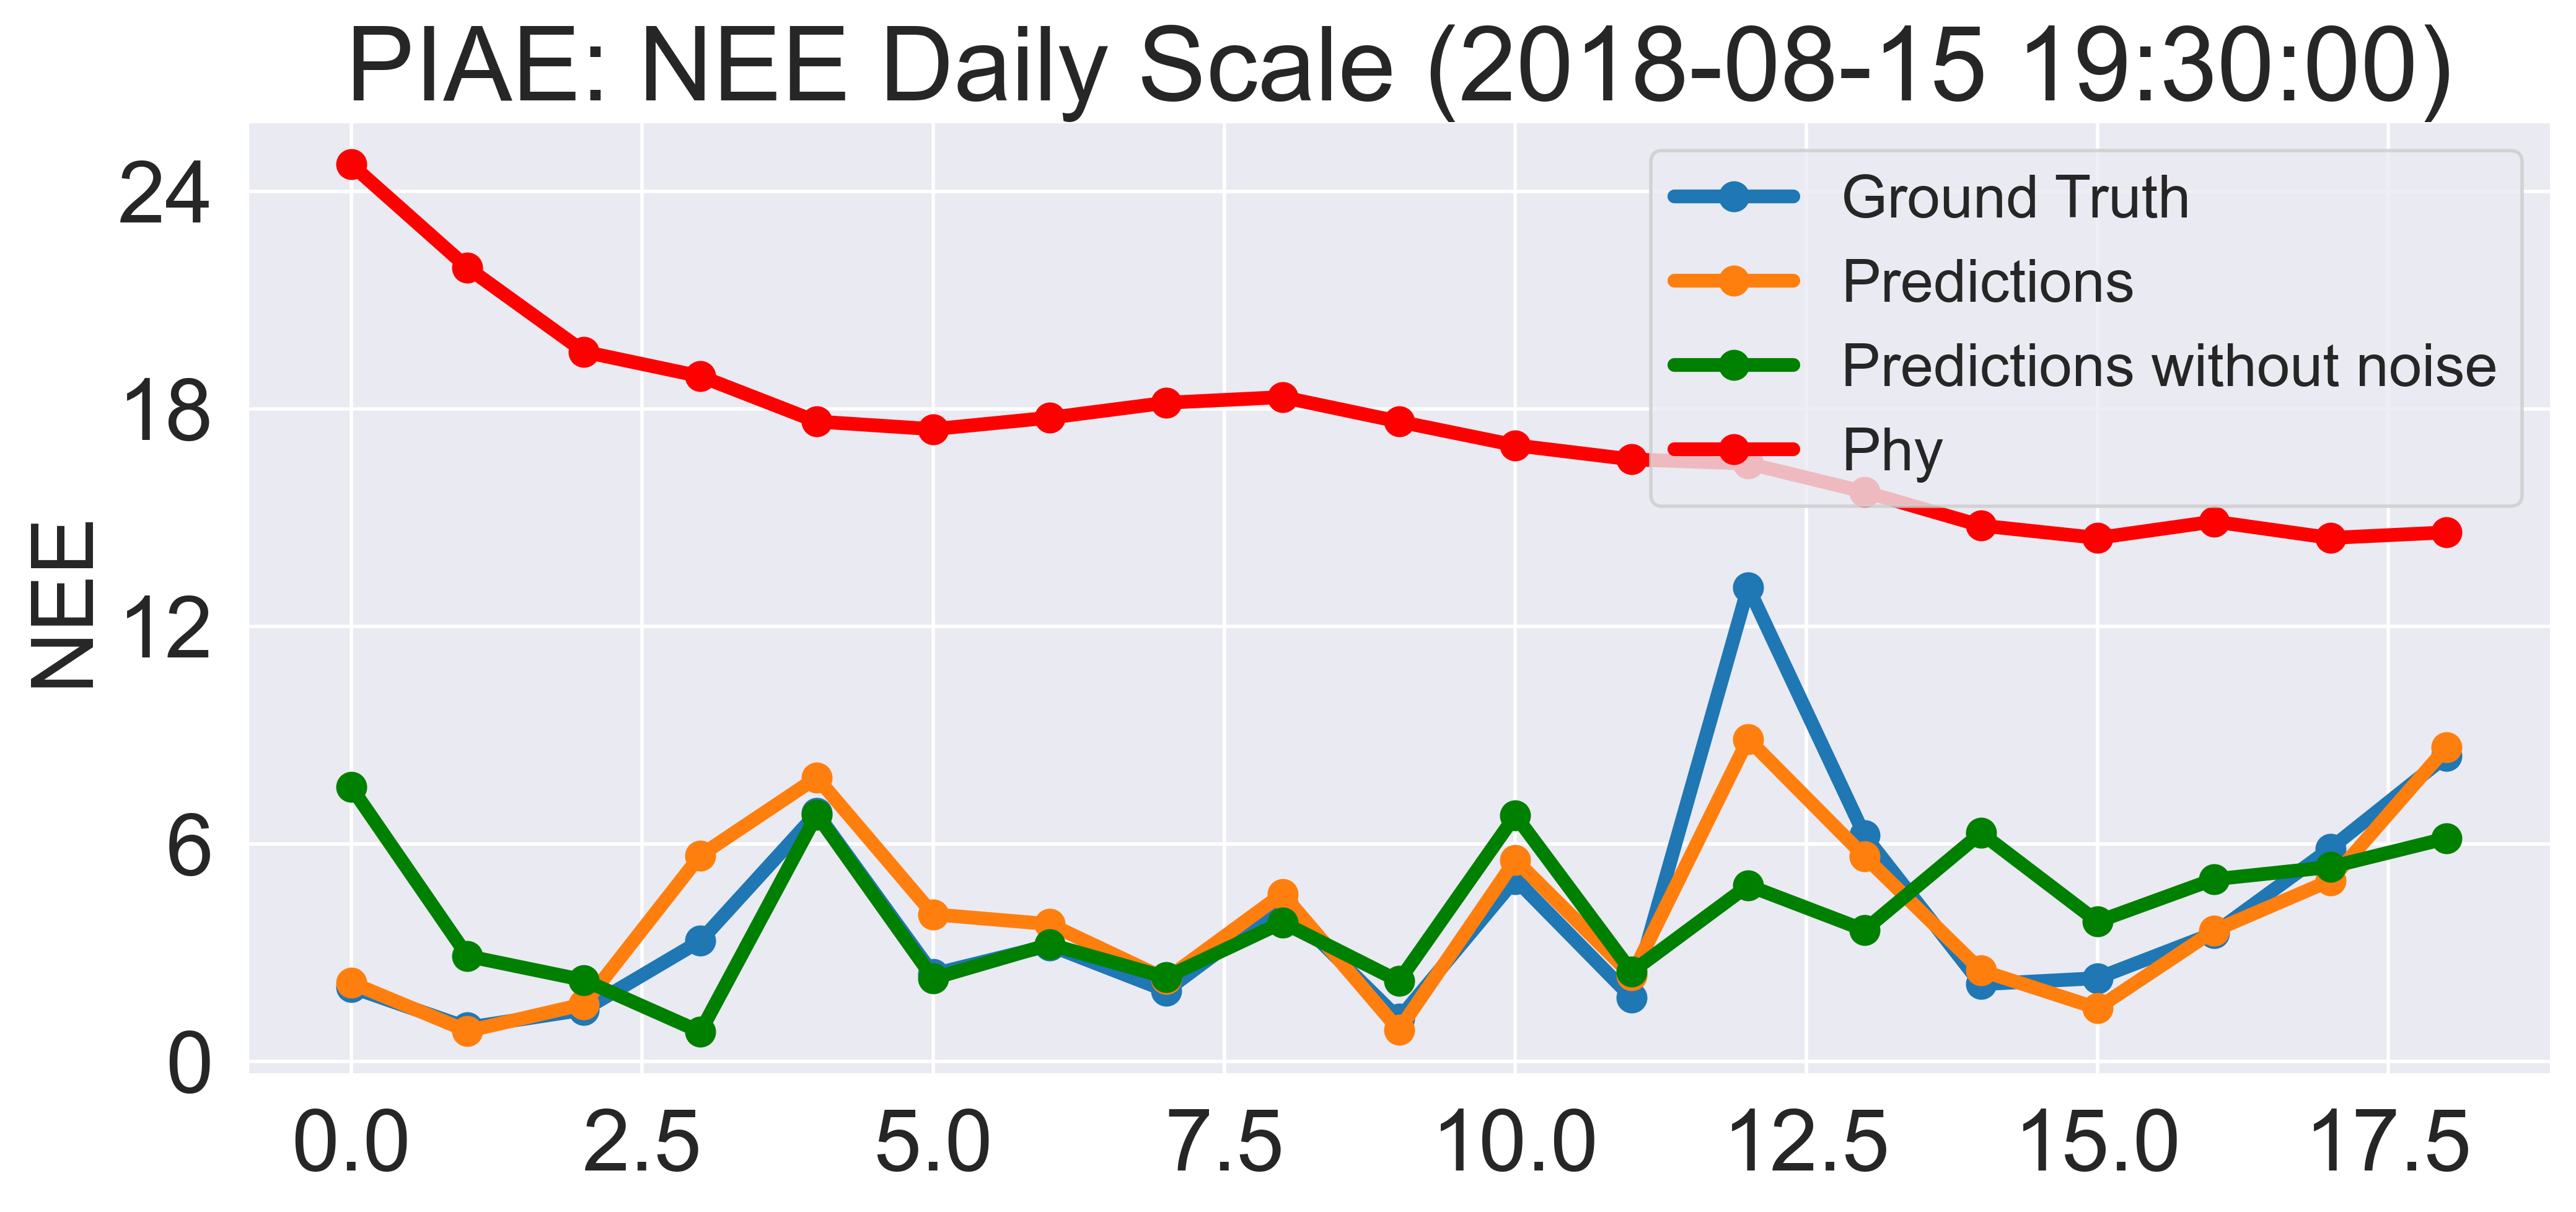

In [66]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 1).values

date = test_data.DateTime[mask].iloc[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten() 
preds_vis_raw = preds.nee[mask].flatten() - preds.noise[mask].flatten()
phy = test_data['NEE_phy'][mask].values.flatten() 

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.plot(preds_vis_raw, 'go-', color="green", linewidth=4, markersize=8)
ax.plot(phy, 'go-', color="red", linewidth=4, markersize=8)

# Calculate final mean prediction
mean_prediction = preds_vis_raw + preds.noise_mus[mask]

# Calculate prediction intervals
z_score = 1.96  # For 95% confidence
lower_bound = mean_prediction - z_score * preds.noise_stds[mask]
upper_bound = mean_prediction + z_score * preds.noise_stds[mask]


plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")


ax.legend(["Ground Truth", "Predictions", "Predictions without noise", "Phy"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

fig.savefig("piae_nee_night_daily.png", bbox_inches='tight')


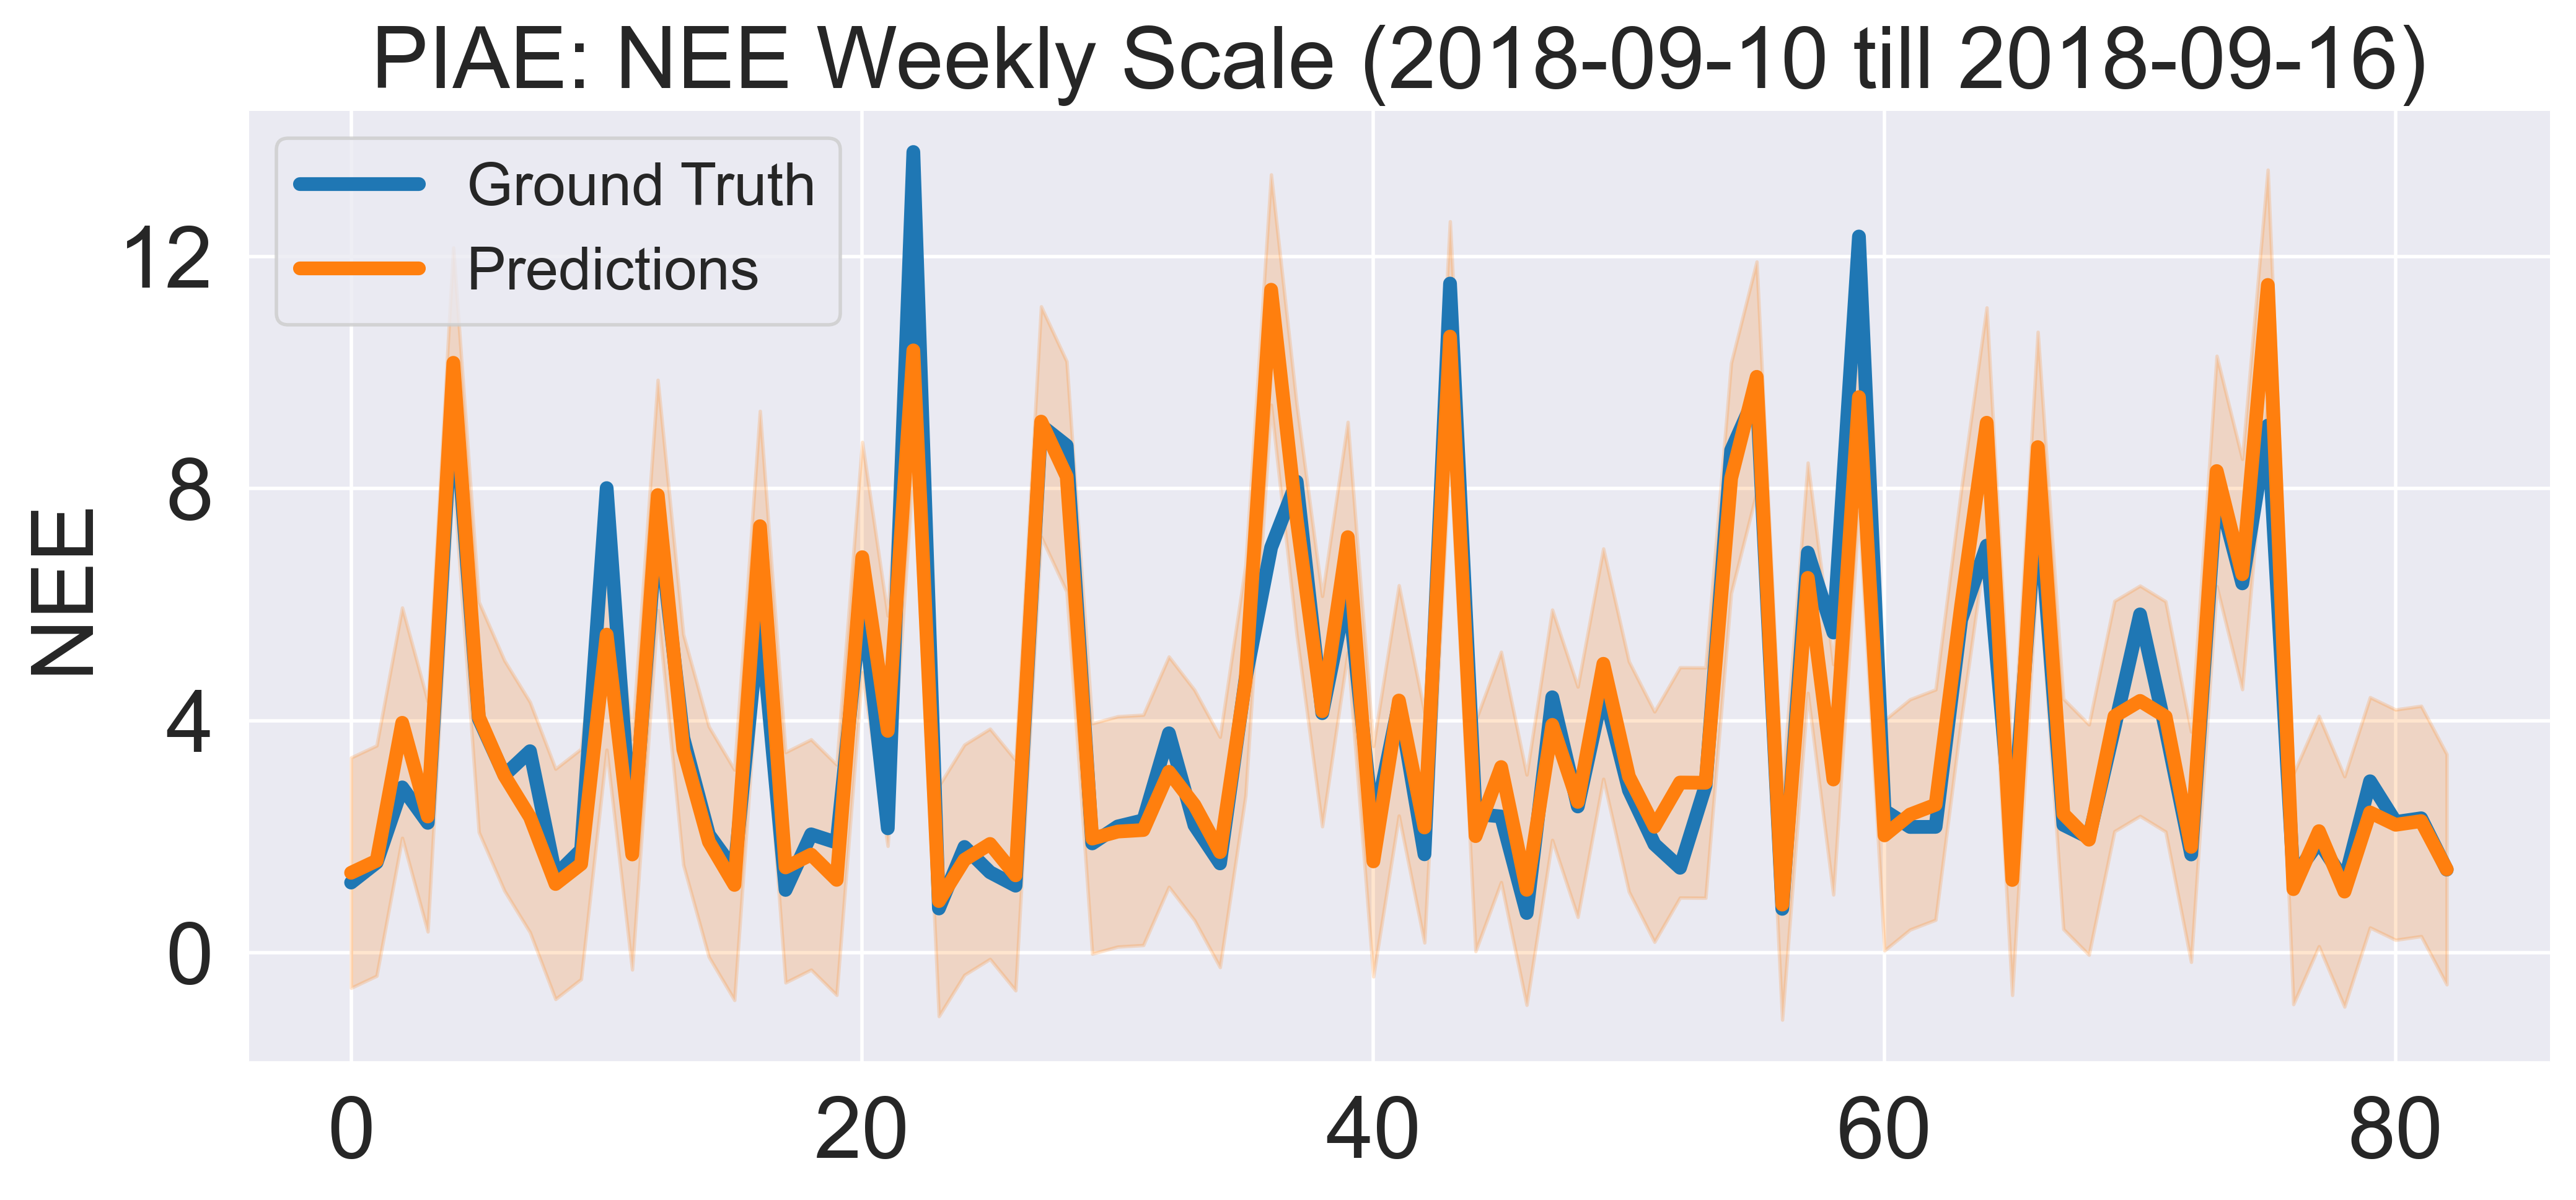

In [67]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 4

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()


fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)

residuals = gt_vis - preds_vis
sigma_residual = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimator
z_score = 1.96  # 95% confidence interval
lower_bound = preds_vis - z_score * sigma_residual
upper_bound = preds_vis + z_score * sigma_residual

plt.fill_between(np.arange(len(preds_vis)), lower_bound, upper_bound, color="#ff7f0e", alpha=0.2, label="95% Prediction Interval")


ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_weekly.png", bbox_inches='tight')


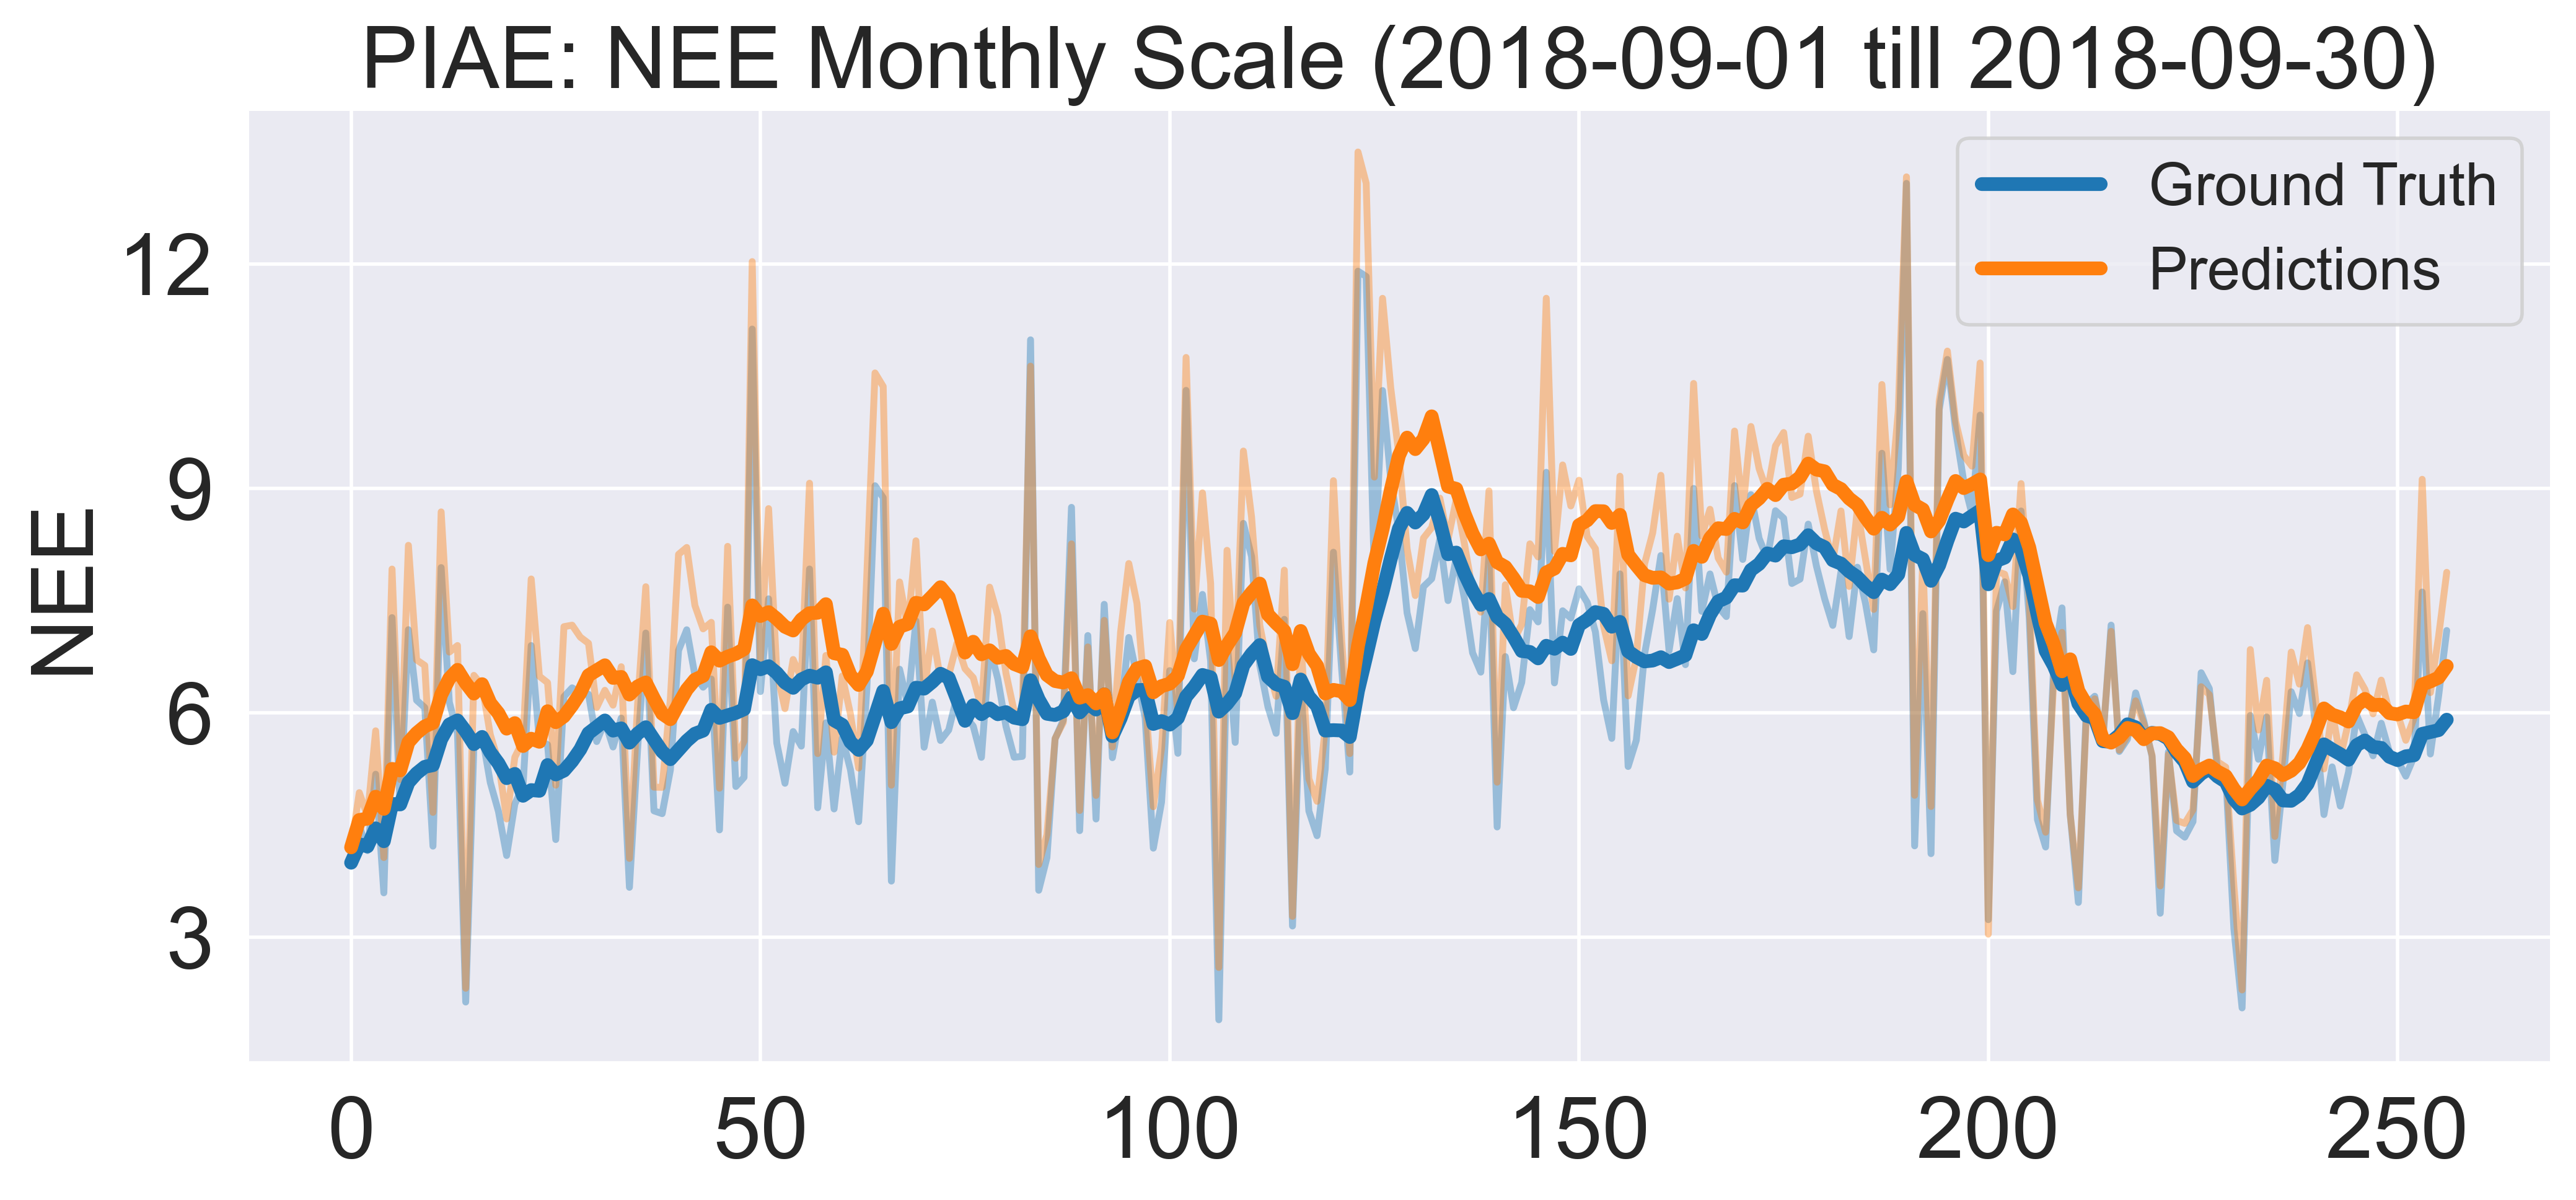

In [96]:
### Monthly

mask = (test_data.DateTime.dt.year == 2018) & (test_data.DateTime.dt.month == 9)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Monthly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_monthly.png", bbox_inches='tight')

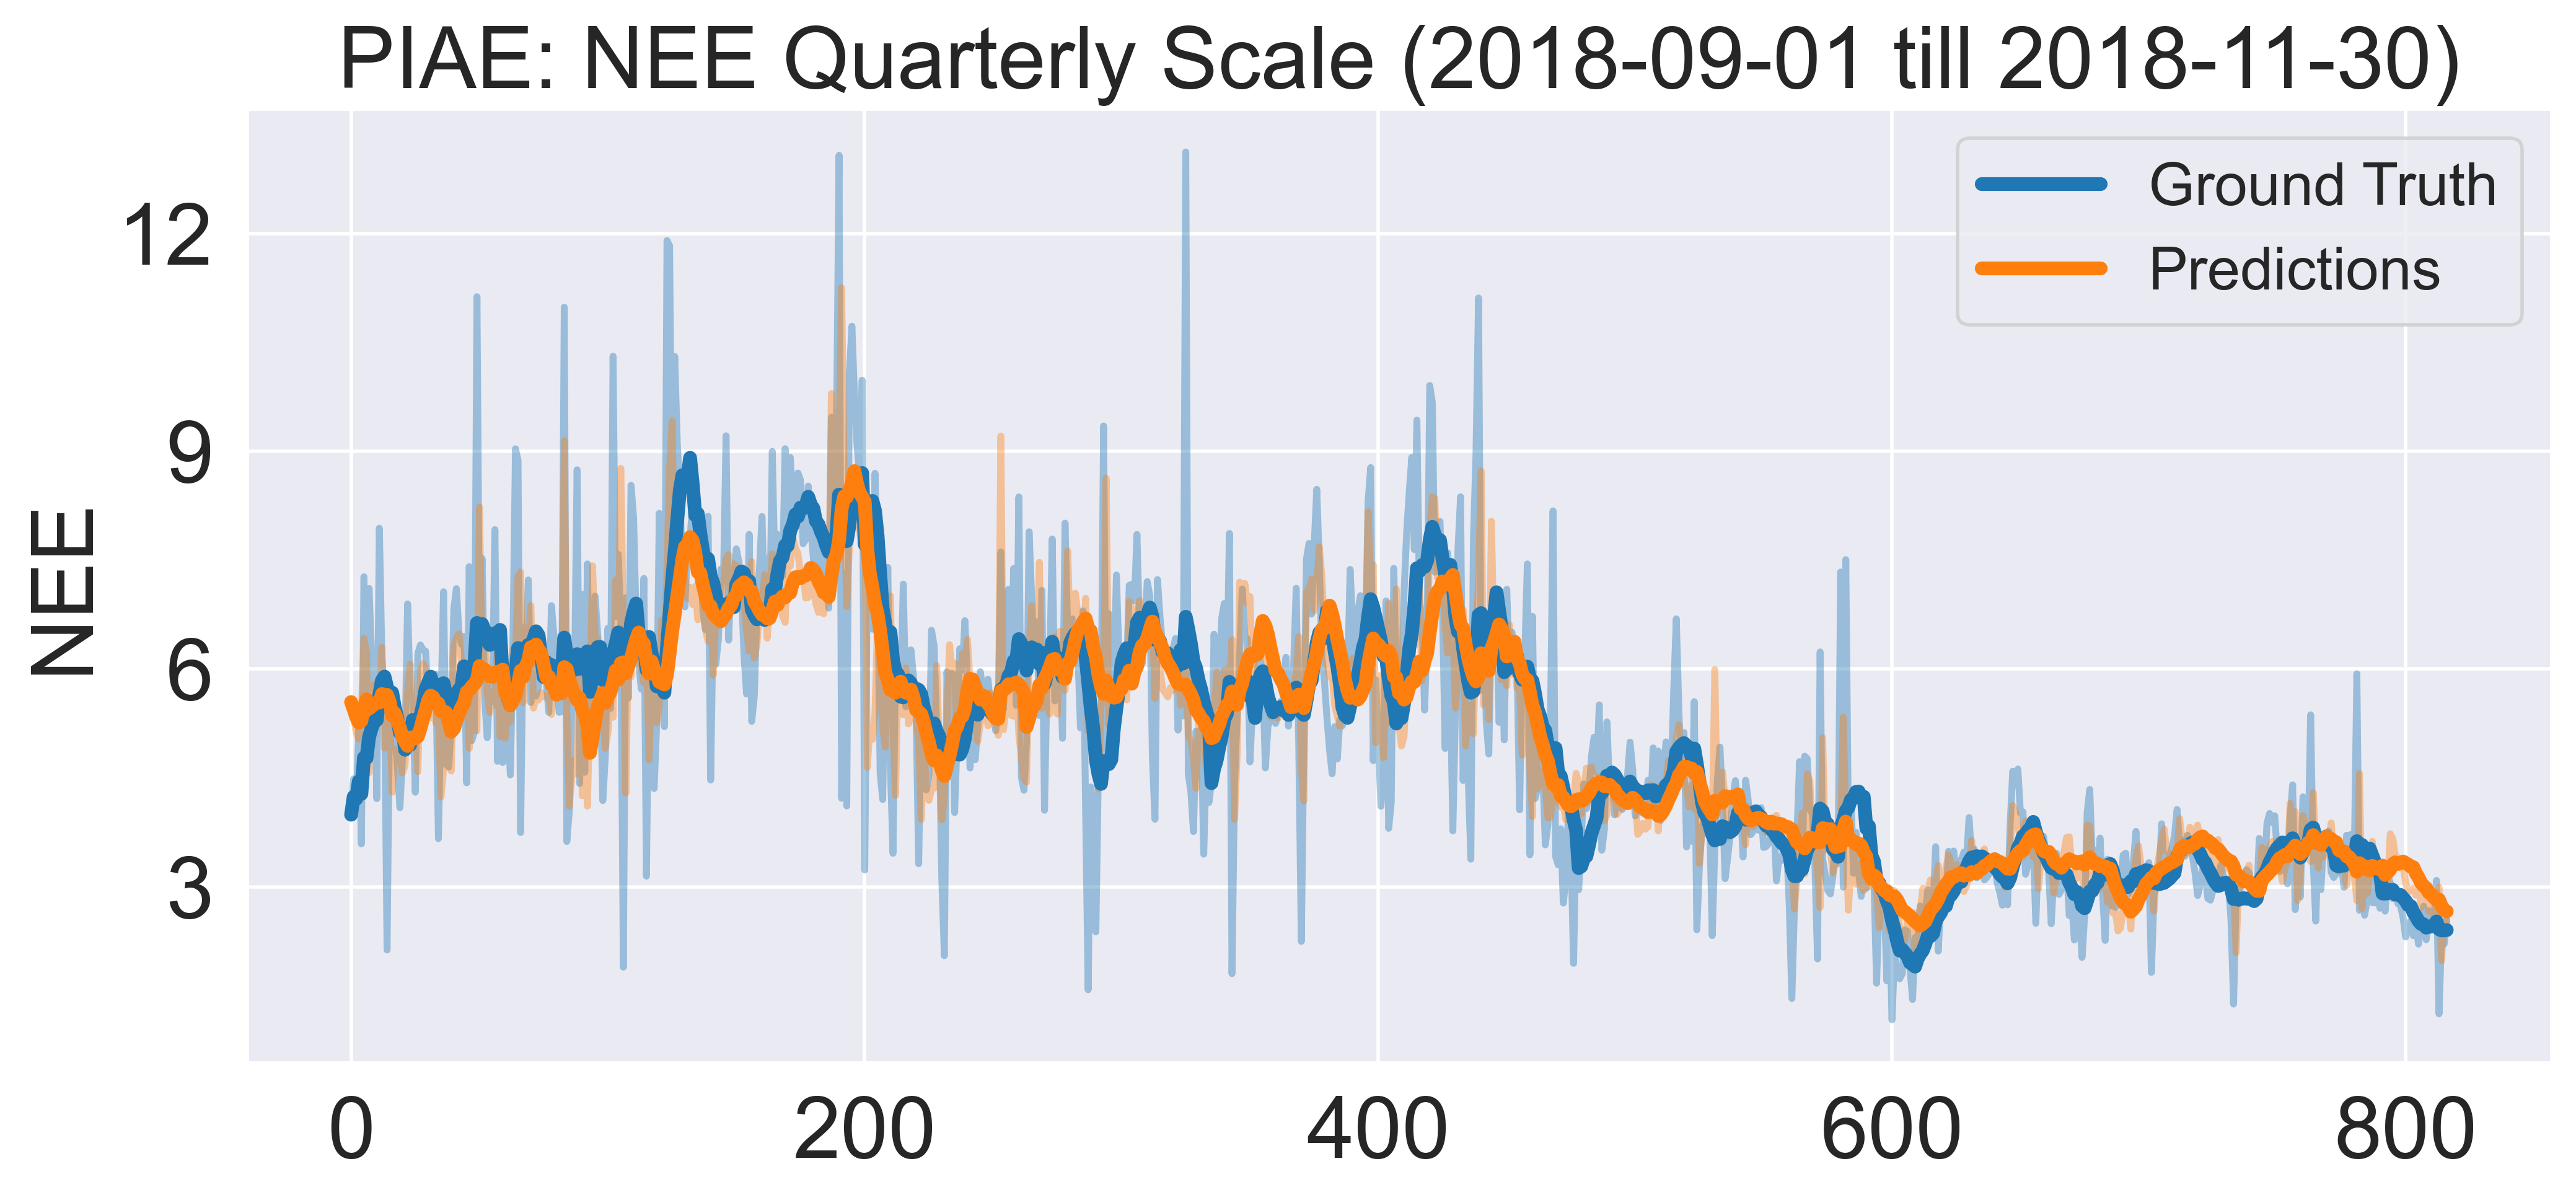

In [98]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2018) & (test_data.season == 4)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_quarterly.png", bbox_inches='tight')

## Training on MMD now for noise modelling

In [67]:
best_test_loss = float('inf')
best_model_path = save_dir.joinpath('best_model.pth')

In [68]:
epoch = 0

##### Control Room

In [69]:
# CONTROL ROOM
loss_fn = MMD_loss()
for g in optimizer.param_groups:
    g['lr'] = 0.001

##### Back to training

In [70]:

loss_name = "MSE" if str(loss_fn) == 'MSELoss()' else "MMD"


while epoch < num_epochs:

    print(colored("Epoch: {}".format(epoch), "red"))
    train_loss = []
    test_loss = []
    
    train_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_temp_loss": [] , "physics_loss": [] , "mmd_f_loss": []})
    # Example of iterating over the DataLoader in the training loop
    for batch in train_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device)
        b = batch['bNEE'].to(device)
        dtemp = batch['dT'].to(device)
        nee = batch['NEE'].to(device)
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss

        train_losses.mmd_loss_nee.append(mmd_loss_nee)
        train_losses.mmd_loss_E0.append(mmd_loss_E0)
        train_losses.mmd_loss_rb.append(mmd_loss_rb)
        train_losses.mmd_temp_loss.append(mmd_temp_loss)
        train_losses.physics_loss.append(physics_loss)
        train_losses.mmd_f_loss.append(mmd_f_loss)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())
    
    print(colored("Training Loss: {}".format(np.mean(train_loss)), "blue"))
    
    writer.add_scalar(f"Train Loss {loss_name}", np.mean(train_loss), epoch)
    
    for col in train_losses.keys():
        l = [x.cpu().detach().numpy() for x in train_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Train Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n")

    test_losses = DotMap({"mmd_loss_nee": [], "mmd_loss_E0": [], "mmd_loss_rb": [] , "mmd_temp_loss": [] , "physics_loss": [] , "mmd_f_loss": []})

    for batch in test_data_loader:
        x = batch['X'].to(device)
        k = batch['k'].to(device)
        f = batch['dNEE'].to(device)
        dtemp = batch['dT'].to(device)
        nee = batch['NEE'].to(device)
                
        nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x)
        
        # Extract E0 and rb predictions
        E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]

        z_prior = torch.randn_like(z)
        # Compute loss
        mmd_loss_nee, mmd_loss_E0, mmd_loss_rb , mmd_temp_loss , physics_loss , mmd_f_loss = loss_function(nee_pred, nee.view(-1, 1), z, z_prior, dT_dt_pred, dtemp.view(-1, 1), k_pred, k, f_pred, f.view(-1, 1), residual, loss_fn)
        loss = mmd_loss_nee+ mmd_loss_E0+ mmd_loss_rb + mmd_temp_loss + physics_loss + mmd_f_loss
        test_loss.append(loss.cpu().detach().numpy())

        test_losses.mmd_loss_nee.append(mmd_loss_nee)
        test_losses.mmd_loss_E0.append(mmd_loss_E0)
        test_losses.mmd_loss_rb.append(mmd_loss_rb)
        test_losses.mmd_temp_loss.append(mmd_temp_loss)
        test_losses.physics_loss.append(physics_loss)
        test_losses.mmd_f_loss.append(mmd_f_loss)
        
    print(colored("Test Loss: {}".format(np.mean(test_loss)), "red"))
    writer.add_scalar(f"Test Loss {loss_name}", np.mean(test_loss), epoch)
    
    for col in test_losses.keys():
        l = [x.cpu().detach().numpy() for x in test_losses[col]]
        print(col, np.mean(l), end=" ")
        writer.add_scalar(f"Test Loss [{col}] {loss_name}", np.mean(l), epoch)
    print("\n\n")

    # Save best model
    if epoch % 5 == 0 and np.mean(test_loss) < best_test_loss:
            best_test_loss = np.mean(test_loss)
            torch.save(model.state_dict(), best_model_path)
            print(colored(f'New best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}',  "light_grey"))

    scheduler.step(np.mean(test_loss))
    epoch += 1




Epoch: 0
Training Loss: 5.7086920738220215
mmd_loss_nee 2.2601697 mmd_loss_E0 0.76293576 mmd_loss_rb 1.1806642 mmd_temp_loss 0.79320633 physics_loss 0.0 mmd_f_loss 0.71171653 

Test Loss: 6.389523029327393
mmd_loss_nee 1.9351652 mmd_loss_E0 0.64349264 mmd_loss_rb 2.39282 mmd_temp_loss 0.7585591 physics_loss 0.0 mmd_f_loss 0.6594868 


New best model saved at epoch 1 with test loss: 6.3895
Epoch: 1
Training Loss: 4.361454010009766
mmd_loss_nee 1.962885 mmd_loss_E0 0.36370263 mmd_loss_rb 1.0544231 mmd_temp_loss 0.3175122 physics_loss 0.0 mmd_f_loss 0.6629309 

Test Loss: 3.3803048133850098
mmd_loss_nee 1.7110729 mmd_loss_E0 0.34815282 mmd_loss_rb 0.49913153 mmd_temp_loss 0.16379634 physics_loss 0.0 mmd_f_loss 0.65815115 


Epoch: 2
Training Loss: 3.8038406372070312
mmd_loss_nee 1.8805873 mmd_loss_E0 0.19171569 mmd_loss_rb 0.9726154 mmd_temp_loss 0.22222522 physics_loss 0.0 mmd_f_loss 0.5366968 

Test Loss: 4.810490131378174
mmd_loss_nee 1.7789376 mmd_loss_E0 0.2776704 mmd_loss_rb 2.04547

KeyboardInterrupt: 

In [71]:
model.eval()

PIAE_SDE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
  )
  (nee_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (temp_derivative_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=1, bias=True)
  )
  (k_decoder): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=2, bias=True)
    (4): ReLU()
  )
)

In [72]:
preds = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": [], "z": []})
gt = DotMap({"nee": [], "E0": [], "rb": [] , "dtemp": [] , "f": []})


for batch in test_data_loader:
    x = batch['X'].to(device)
    k = batch['k'].to(device)
    f = batch['dNEE'].to(device)
    b = batch['bNEE'].to(device)
    dtemp = batch['dT'].to(device)
    nee = batch['NEE'].to(device)
            
    nee_pred, dT_dt_pred, k_pred, f_pred, z, residual = model(x)
    E0_pred, rb_pred = k_pred[:, 0], k_pred[:, 1]
    
    preds.nee.extend(nee_pred.cpu().detach().numpy().tolist())
    preds.E0.extend(E0_pred.cpu().detach().numpy().tolist())
    preds.rb.extend(rb_pred.cpu().detach().numpy().tolist())
    preds.dtemp.extend(dT_dt_pred.cpu().detach().numpy().flatten().tolist())
    preds.f.extend(f_pred.cpu().detach().numpy().tolist())
    preds.z.extend(z.cpu().detach().numpy().tolist())
    
    gt.nee.extend(nee.cpu().detach().numpy().tolist())
    gt.E0.extend(k[:, 0].cpu().detach().numpy().tolist())
    gt.rb.extend(k[:, 1].cpu().detach().numpy().tolist())
    gt.f.extend(f.cpu().detach().numpy().tolist())
    gt.dtemp.extend(dtemp.cpu().detach().numpy().tolist())

for col in preds:
    preds[col] = np.array(preds[col])
    if len(preds[col].shape) > 1 and preds[col].shape[1] == 1:
        preds[col] = preds[col].flatten()
for col in gt:
    gt[col] = np.array(gt[col])
    if len(gt[col].shape) > 1 and gt[col].shape[1] == 1:
        gt[col] = gt[col].flatten()

In [73]:
print(colored("Metrics ", "red"))
for col in gt:
    
    mmd = compute_mmd(gt[col], preds[col])
    wasstn = wasserstein_distance(gt[col], preds[col])
    kl = compute_kl_divergence(gt[col], preds[col])
    mae = mean_absolute_error(gt[col], preds[col])
    r2 = r2_score(gt[col], preds[col])
    print(colored(col, "blue"), "\nMMD: {}, Wasstn: {}, KL: {}, MAE: {}, R2: {}".format(mmd, wasstn, kl, mae, r2))
    config.eval.mae[col] = mean_absolute_error(gt[col], preds[col])
    config.eval.r2[col] = r2_score(gt[col], preds[col])

with open(save_dir.joinpath("config.json"), "w") as fp:
    json.dump(config.toDict(), fp)

Metrics 
nee 
MMD: 0.04964816990187348, Wasstn: 0.13031518517728063, KL: 0.13335490986327686, MAE: 1.1115466750887566, R2: 0.574903199875495
E0 
MMD: 0.11021267201432779, Wasstn: 0.822791964784407, KL: 0.6077282486963288, MAE: 1.114507809195874, R2: 0.9975573571307922
rb 
MMD: 0.03777672466706936, Wasstn: 0.13905951634305838, KL: 0.6188039342107797, MAE: 0.2571809713231902, R2: 0.9792450210936386
dtemp 
MMD: 0.06941862133982124, Wasstn: 0.10504106700523719, KL: 2.475527204846719, MAE: 0.11218209476813679, R2: -929.5103831651008
f 
MMD: 0.0022951418296154025, Wasstn: 0.016919591604178393, KL: 0.7659079913367797, MAE: 0.03585930135793659, R2: -0.2379537721415972


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_21486/1391182150.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_21486/1391182150.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)


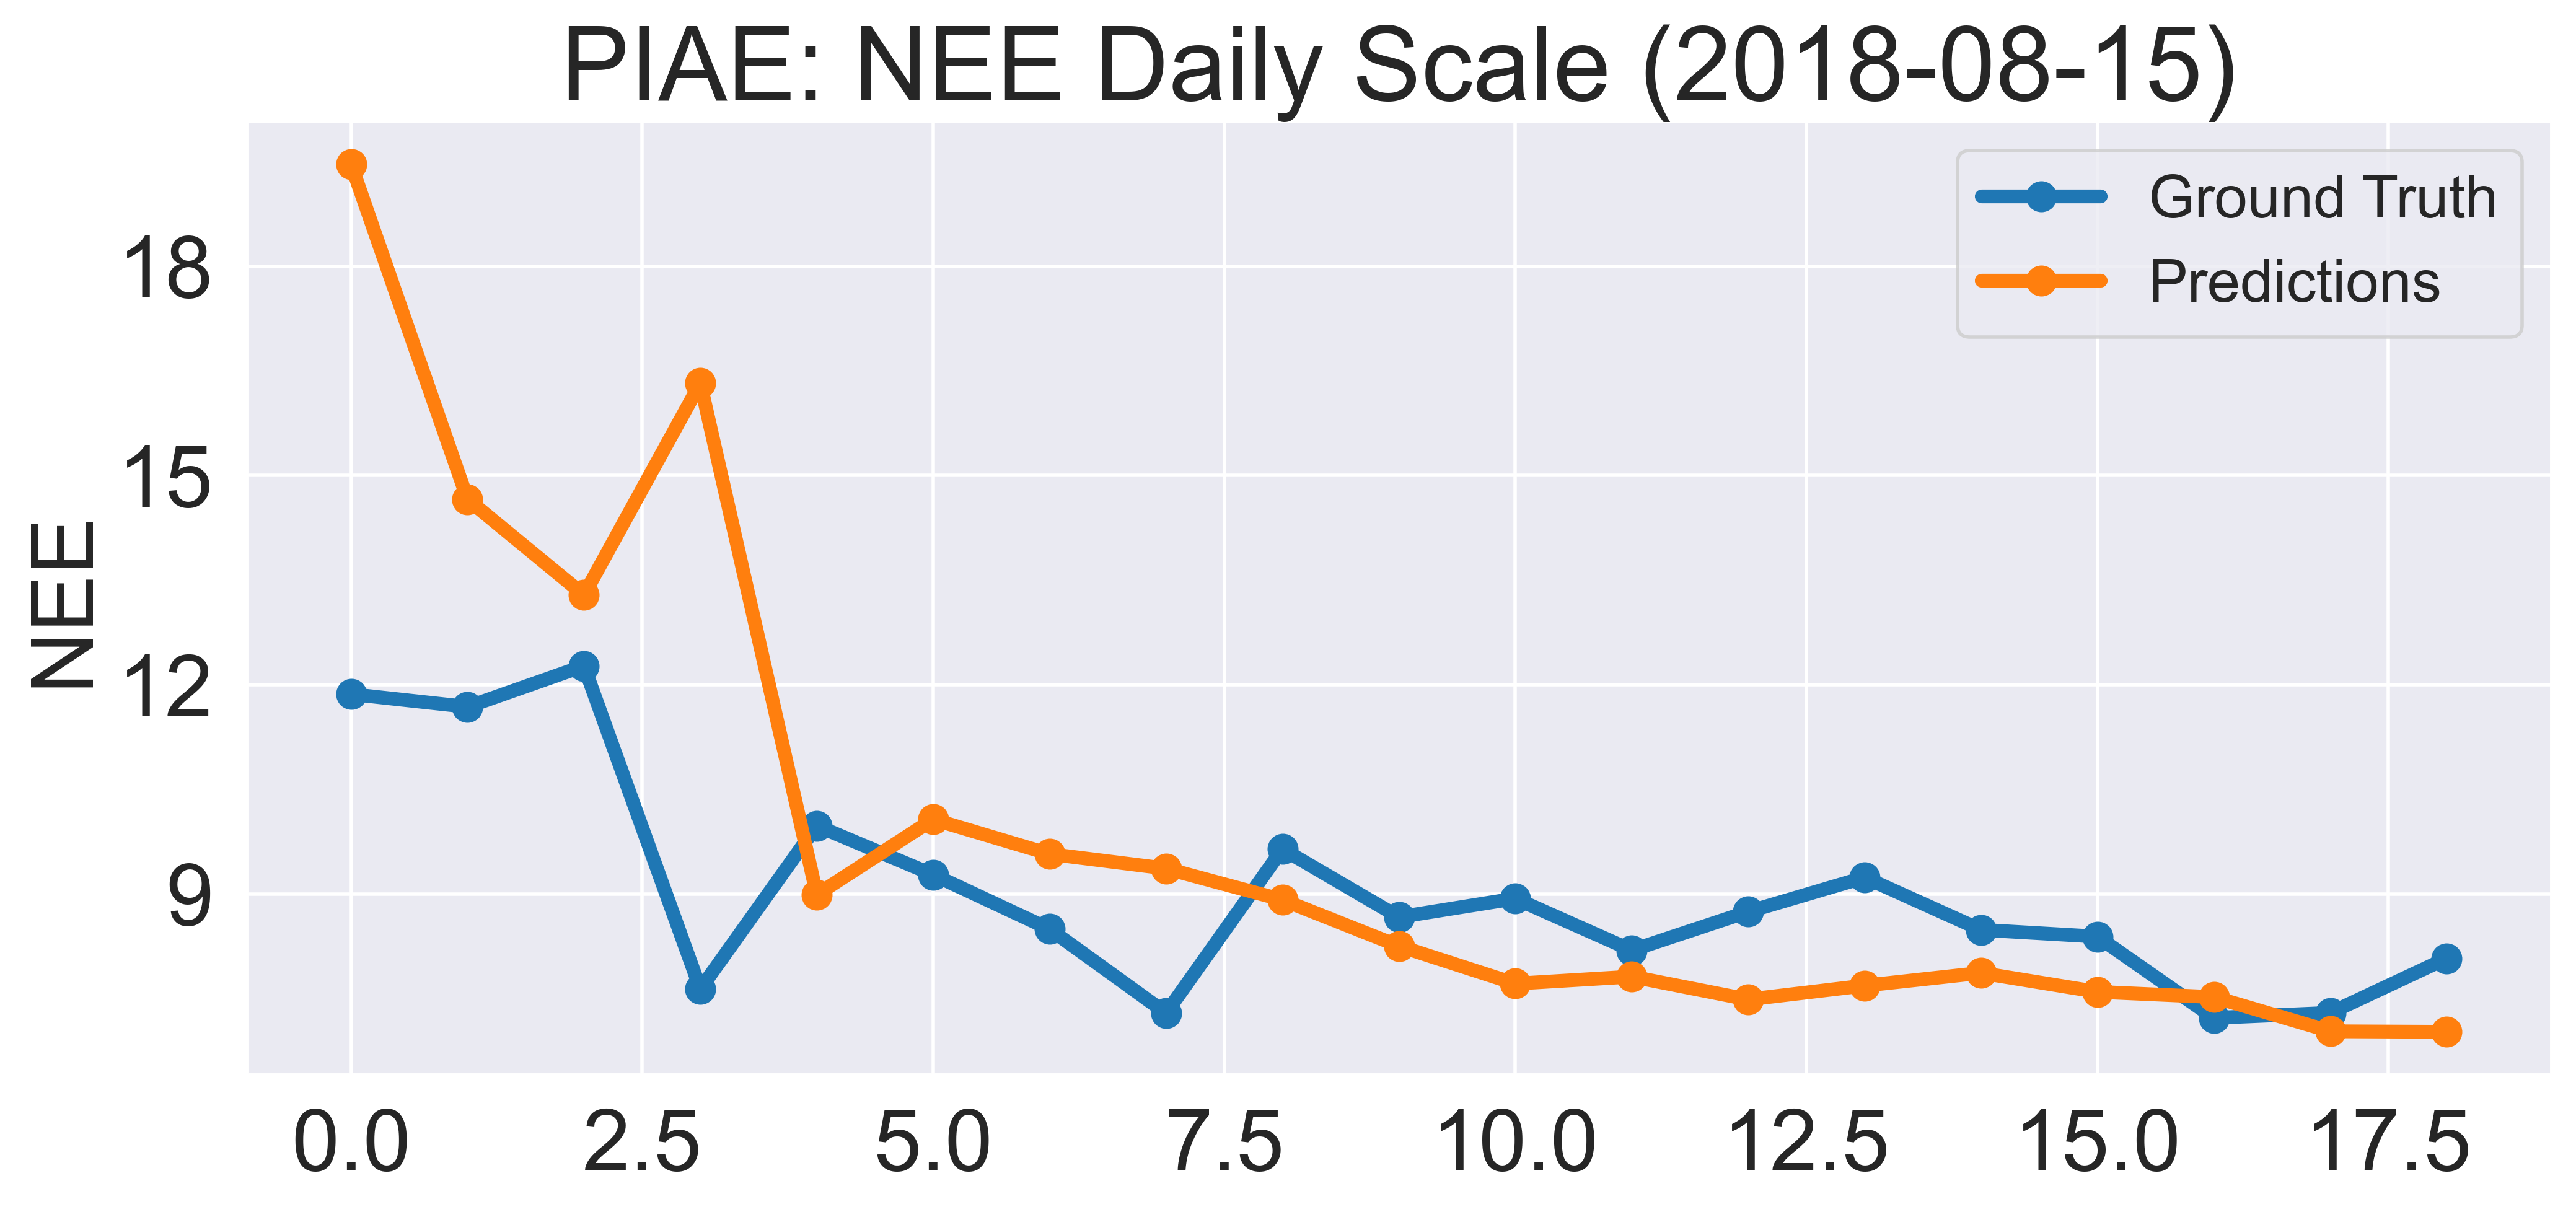

In [133]:
### Daily


test_data['time_diff'] = test_data.DateTime.diff()

test_data['daily_group'] = (test_data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (test_data['daily_group'] == 1).values

date = test_data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]


gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, 'go-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, 'go-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Daily Scale ({date})", fontsize=30)

fig.savefig("piae_nee_night_daily.png", bbox_inches='tight')


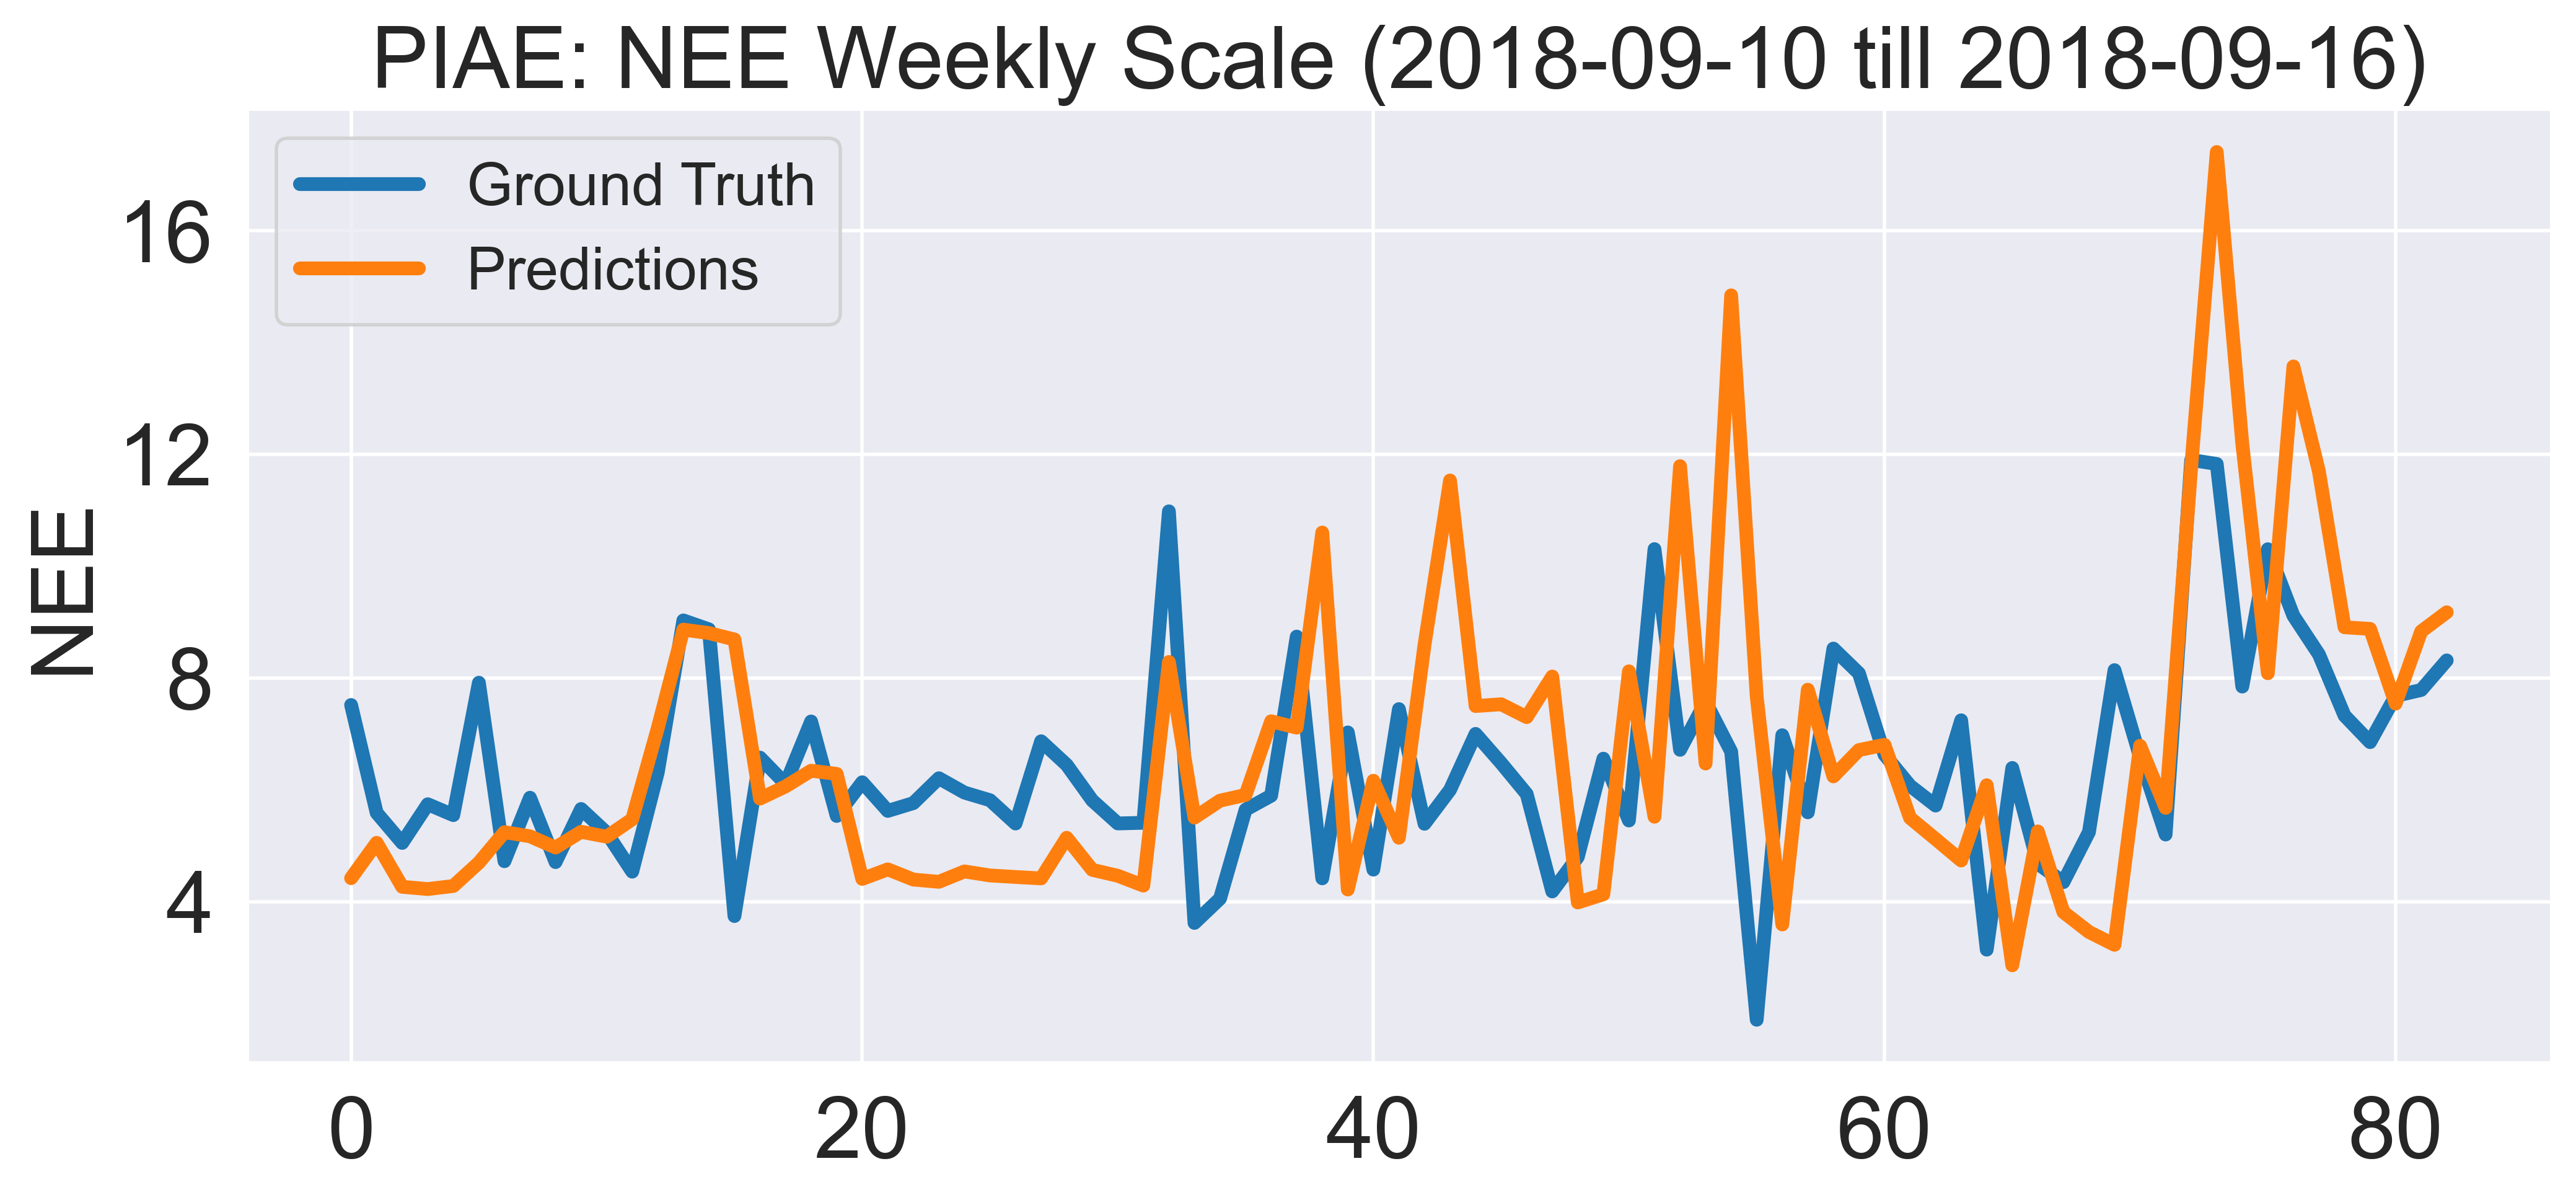

In [134]:
### Weekly

test_data['week_group'] = (test_data['dayofweek'] < test_data['dayofweek'].shift()).cumsum()

mask = test_data.week_group == 4

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, '-', color="#1f77b4", linewidth=4, markersize=8)
ax.plot(preds_vis, '-', color="#ff7f0e", linewidth=4, markersize=8)
ax.legend(["Ground Truth", "Predictions"], fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Weekly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_weekly.png", bbox_inches='tight')


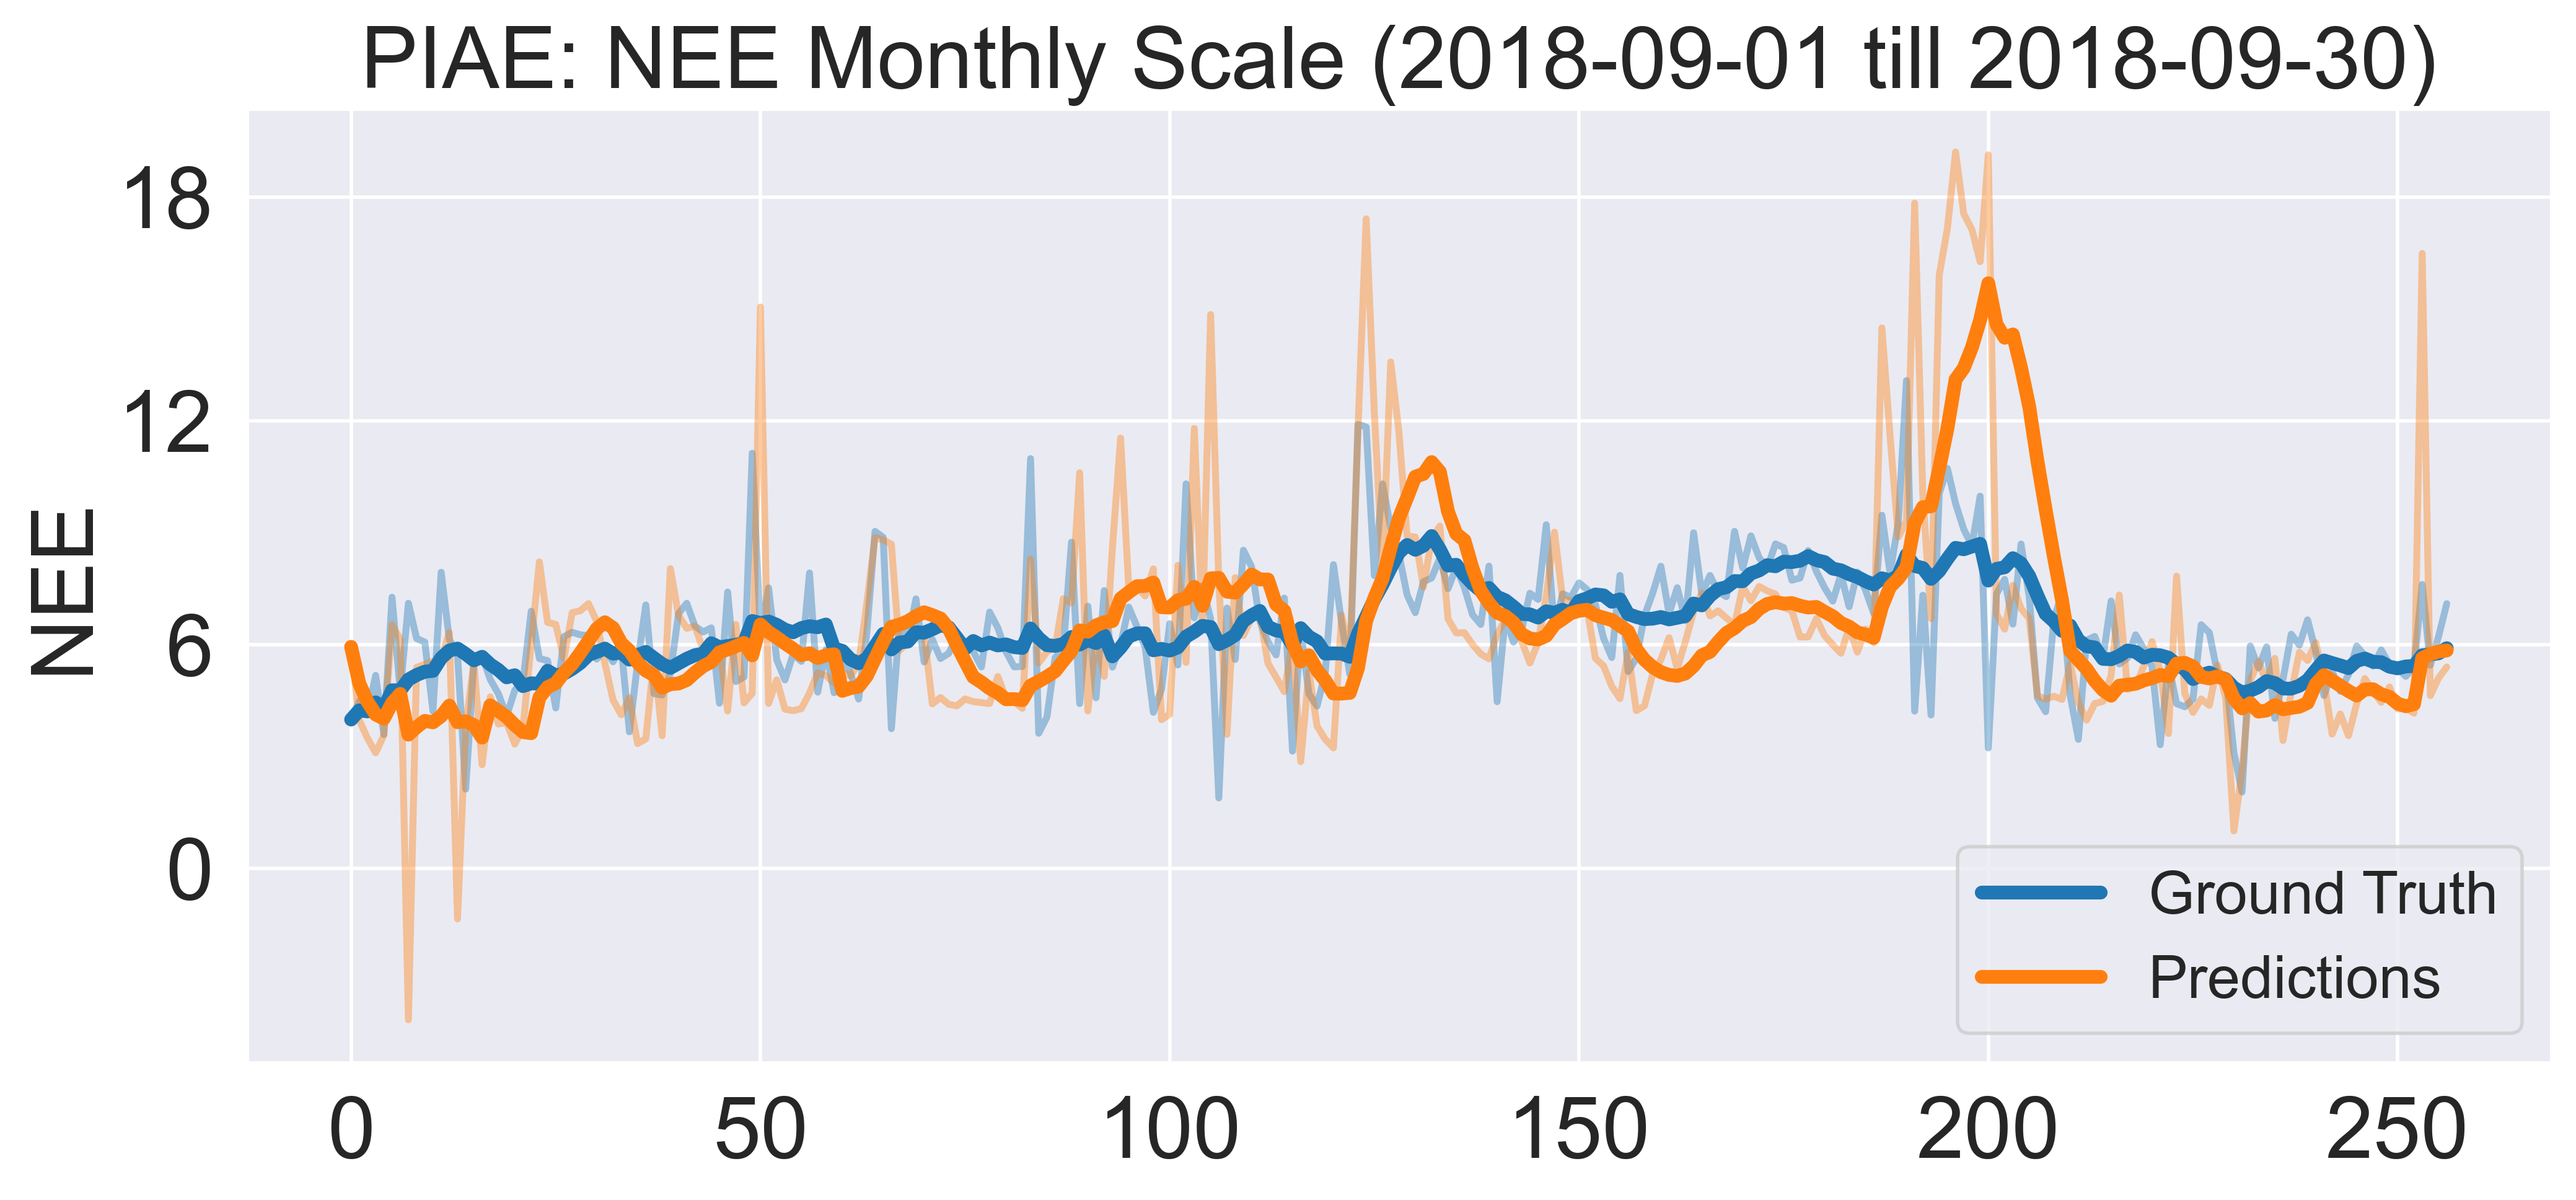

In [135]:
### Monthly

mask = (test_data.DateTime.dt.year == 2018) & (test_data.DateTime.dt.month == 9)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Monthly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_monthly.png", bbox_inches='tight')

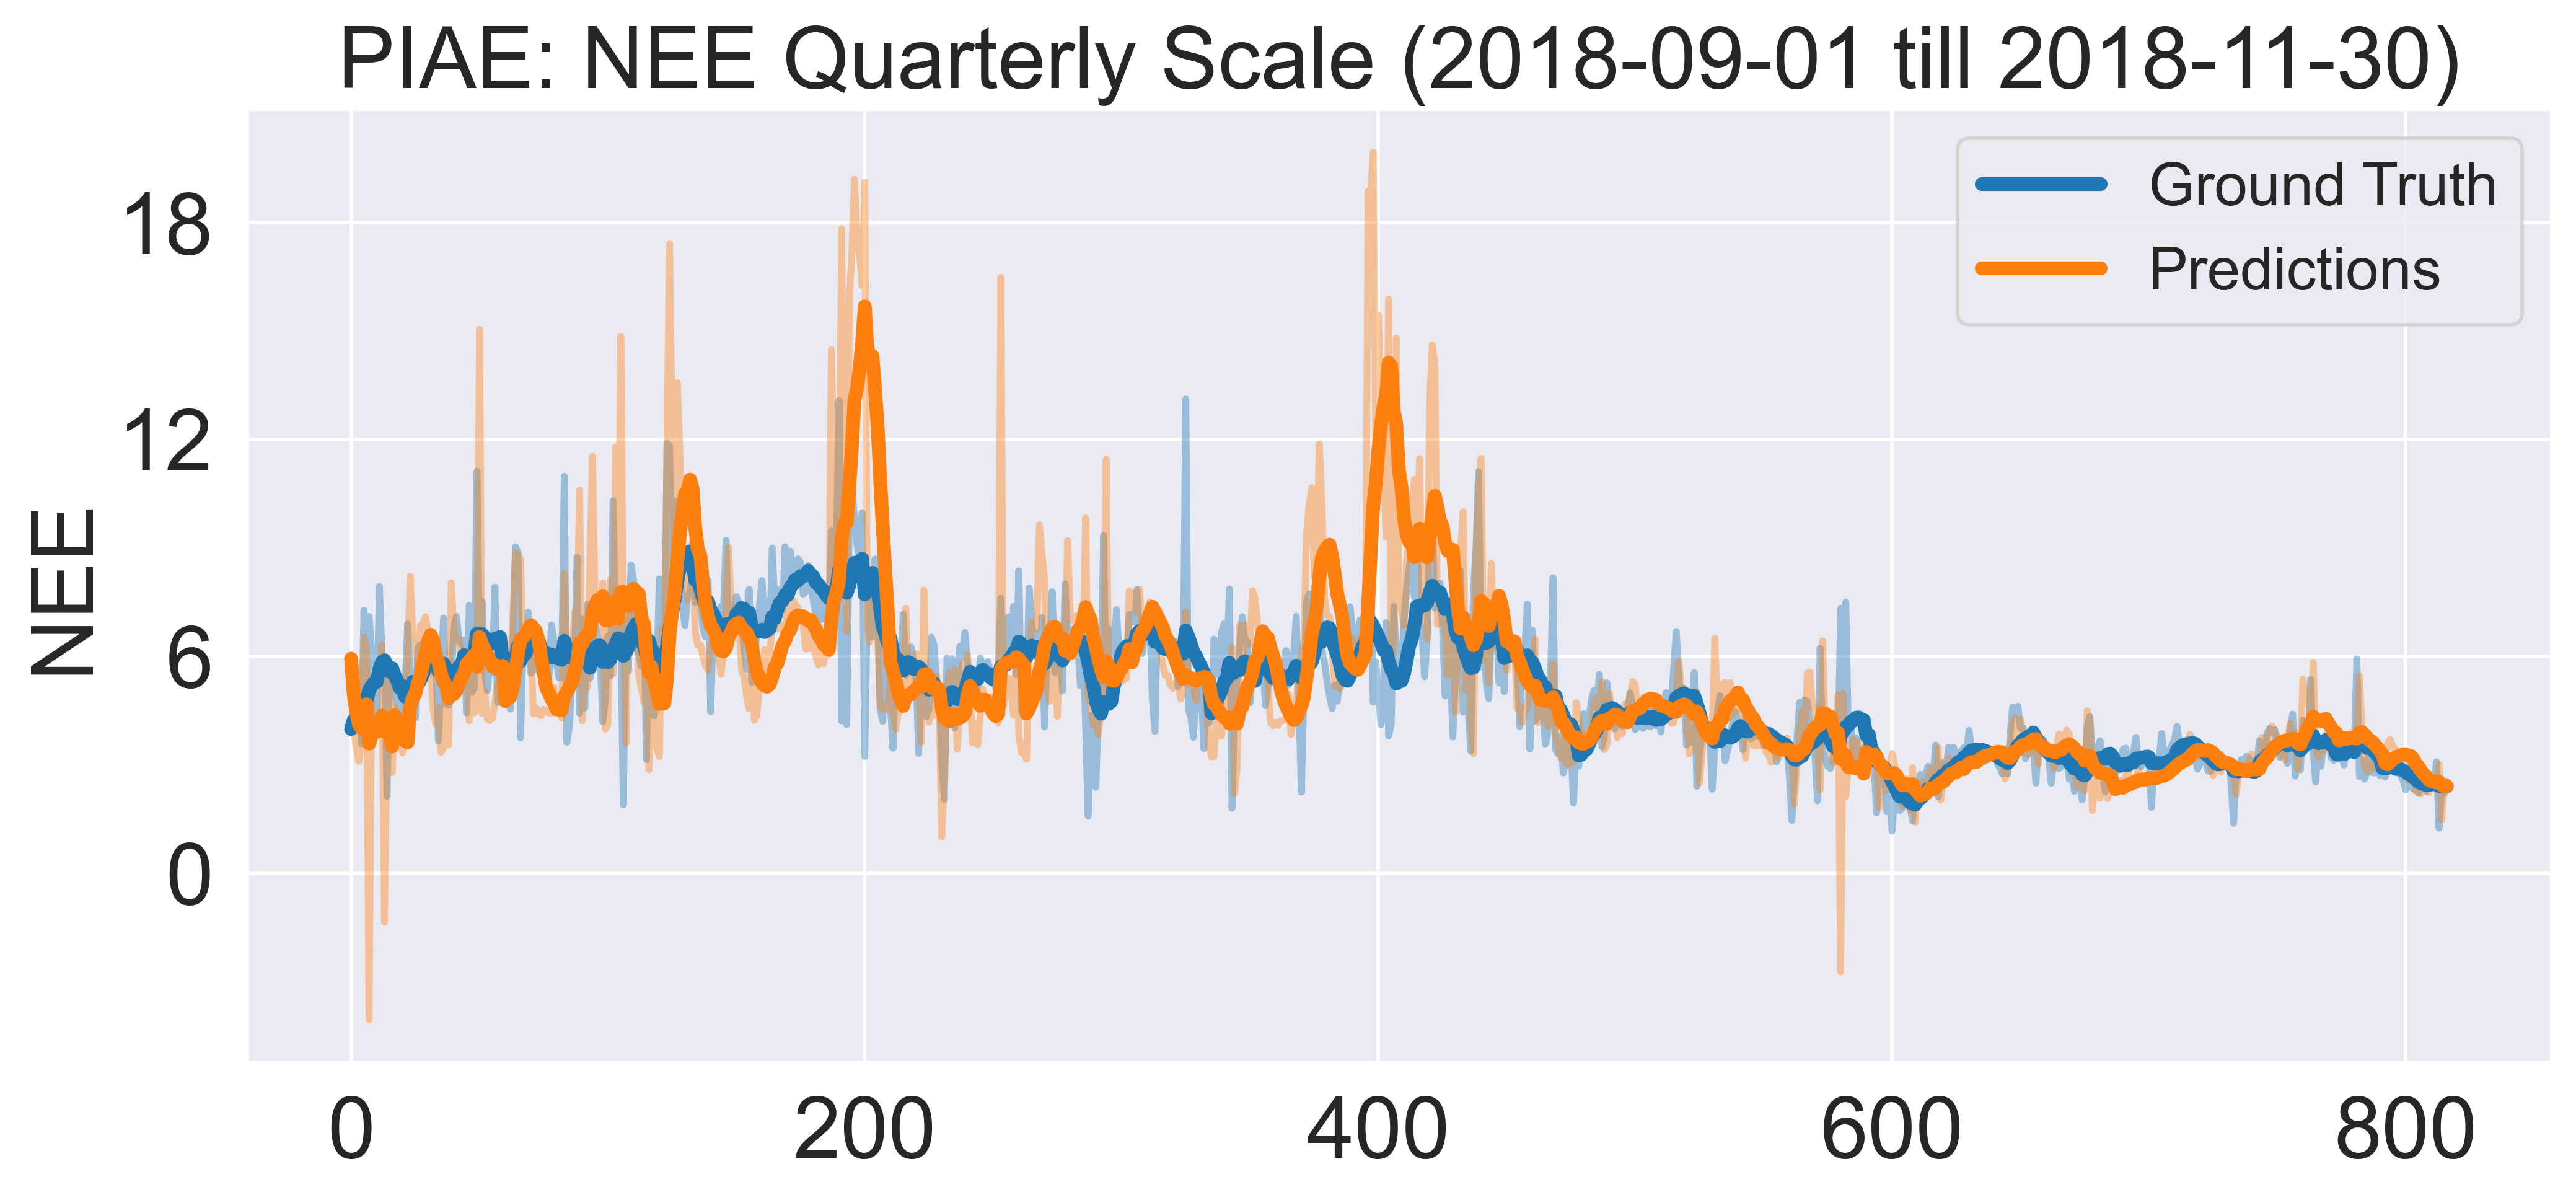

In [136]:
### Quarterly

test_data.season.unique()

mask = (test_data.DateTime.dt.year == 2018) & (test_data.season == 4)

date1 = test_data.DateTime[mask].iloc[0]
date2 = test_data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = gt.nee[mask]
preds_vis = preds.nee[mask].flatten()

window_size = 10
gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.4, color="#1f77b4", linewidth=2)
ax.plot(preds_vis, alpha=0.4, color="#ff7f0e", linewidth=2)
ax.plot(gt_vis_smoothed, color="#1f77b4", label="Ground Truth", linewidth=4)
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="Predictions", linewidth=4)
ax.legend(fontsize='x-large')
ax.set_ylabel("NEE", fontsize=25)
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=25)

ax.set_title(f"PIAE: NEE Quarterly Scale ({date})", fontsize=25)
fig.savefig("piae_nee_night_quarterly.png", bbox_inches='tight')